# Load the Data
## Peeringdb

In [1]:
import json
from pathlib import Path
import pandas as pd

filepath = Path('../../preprocessing/data/peeringdb/peeringdb_2_dump_2025_10_21.json')

with filepath.open('r', encoding='utf-8') as f:
    dump = json.load(f)

# extract the net.data section and load into a DataFrame
net_data = dump.get('net', {}).get('data')
if net_data is None:
    raise KeyError("JSON does not contain 'net' -> 'data' structure")

net_df = pd.DataFrame(net_data)
net_df['asn'] = net_df['asn'].astype(int)
net_df = net_df[net_df['info_type'] != '']
net_df = net_df[net_df['info_types'].apply(len) == 1]


# show a quick preview
net_df.head()

,id,org_id,name,aka,name_long,website,social_media,asn,looking_glass,route_server,...,policy_ratio,policy_contracts,allow_ixp_update,status_dashboard,rir_status,rir_status_updated,logo,created,updated,status
0,1,8897,GTT Communications (AS4436),Formerly known as nLayer Communications,,http://www.gtt.net,"[{'service': 'website', 'identifier': 'http://...",4436,,,...,True,Required,False,None,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2022-07-27T05:33:22Z,ok
1,2,14,Akamai Technologies,,,https://www.akamai.com/,"[{'service': 'website', 'identifier': 'https:/...",20940,,,...,False,Not Required,False,https://www.akamaistatus.com/,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-10-20T12:16:12Z,ok
2,3,17,DALnet IRC Network,,,http://www.dal.net,"[{'service': 'website', 'identifier': 'http://...",31800,,,...,False,Not Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-01-09T13:42:07Z,ok
3,5,9350,Swisscom,IP-Plus,,http://www.swisscom.com,"[{'service': 'website', 'identifier': 'http://...",3303,,telnet://route-server.ip-plus.net,...,True,Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2025-08-12T06:33:30Z,ok
4,6,23,Cox Communications,Cox Communications,,http://www.cox.com/peering,"[{'service': 'website', 'identifier': 'http://...",22773,,,...,False,Required,False,,ok,2024-06-26T04:47:55Z,None,2004-07-28T00:00:00Z,2022-11-28T22:55:17Z,ok


# Caida AS Names

In [2]:
import io
with open('../../preprocessing/data/caida/20251001.as-org2info.txt', 'r', newline='', encoding='utf-8') as input_file:
    lines = input_file.readlines()   
    # Buffers initialisieren
    aut_lines = []
    org_lines = []
    mode = None
    total_lines = len(lines)
    aut_count = 0
    org_count = 0 

    for i, line in enumerate(lines):
        line = line.strip()
        if line.startswith("# format:aut"):
            mode = "aut"
            continue
        elif line.startswith("# format:org_id"):
            mode = "org"
            continue
        elif line.startswith("#") or not line:
            # Andere Kommentar- oder Leerzeilen überspringen
            continue      
        if mode == "aut":
            aut_lines.append(line)
            aut_count += 1
        elif mode == "org":
            org_lines.append(line)
            org_count += 1
    # StringIO-Objekte aus den gesammelten Zeilen bauen
    aut_buffer = io.StringIO("\n".join(aut_lines))
    org_buffer = io.StringIO("\n".join(org_lines))
    # DataFrames einlesen
    aut_df = pd.read_csv(aut_buffer, sep="|",
                        names=["aut", "changed", "aut_name", "org_id", "opaque_id", "source"], usecols=["aut", "org_id", "source", "changed", "aut_name"])
    org_df = pd.read_csv(org_buffer, sep="|",
                        names=["org_id", "changed", "org_name", "country", "source"], usecols=["org_id", "org_name", "country"])

    # Join the DataFrames
    joined_df = pd.merge(aut_df, org_df, on="org_id", how="left")
SEP_TOKEN = '</s>'
joined_df['text'] = joined_df['aut_name'].astype(str) + SEP_TOKEN + joined_df['org_name'].astype(str)
joined_df.head()

,aut,changed,aut_name,org_id,source,org_name,country,text
0,1,20240618.0,LVLT-1,LPL-141-ARIN,ARIN,"Level 3 Parent, LLC",US,"LVLT-1</s>Level 3 Parent, LLC"
1,2,20231108.0,UDEL-DCN,UNIVER-19-Z-ARIN,ARIN,University of Delaware,US,UDEL-DCN</s>University of Delaware
2,3,20100927.0,MIT-GATEWAYS,MIT-2-ARIN,ARIN,Massachusetts Institute of Technology,US,MIT-GATEWAYS</s>Massachusetts Institute of Tec...
3,4,20230929.0,ISI-AS,USC-32-Z-ARIN,ARIN,University of Southern California,US,ISI-AS</s>University of Southern California
4,5,20200723.0,SYMBOLICS,WGL-117-ARIN,ARIN,WFA Group LLC,US,SYMBOLICS</s>WFA Group LLC


## Join both

In [3]:
peering_df_joined = pd.merge(net_df, joined_df, left_on='asn', right_on='aut', how='left')
peering_df_joined = peering_df_joined[['asn', 'org_name', 'country', 'source', 'info_type', "aut_name"]]
peering_df_joined.head()

,asn,org_name,country,source,info_type,aut_name
0,4436,"GTT Americas, LLC",US,ARIN,NSP,AS-GTT-4436
1,20940,Akamai International B.V.,NL,RIPE,Content,AKAMAI-ASN1
2,31800,DALnet,US,ARIN,Non-Profit,DALNET
3,3303,Swisscom (Schweiz) AG,CH,RIPE,Cable/DSL/ISP,SWISSCOM
4,22773,Cox Communications Inc.,US,ARIN,Cable/DSL/ISP,ASN-CXA-ALL-CCI-22773-RDC


## AS Rank

In [4]:
as_rank_df = pd.read_csv('../../preprocessing/data/asrank/as_rank_df.csv')
as_rank_df.head()

,asn,rank,asnDegree_total,asnDegree_customer,asnDegree_peer,asnDegree_provider,cone_numberAsns,cone_numberPrefixes,cone_numberAddresses
0,3356,1,6613,6545,68,0,53986,873410,3468642119
1,1299,2,2567,2509,58,0,41193,776707,3219679484
2,174,3,6723,6626,97,0,38887,730166,3034352967
3,3257,4,1853,1816,37,0,36040,612491,2791999209
4,2914,5,1541,1483,58,0,25179,576134,2918763154


In [5]:
peering_df_joined_with_asrank = pd.merge(
    peering_df_joined,
    as_rank_df,
    left_on='asn',
    right_on='asn',
    how='left'
)
peering_df_joined_with_asrank['rank'].fillna(peering_df_joined_with_asrank['rank'].median(), inplace=True)
peering_df_joined_with_asrank['asnDegree_total'].fillna(peering_df_joined_with_asrank['asnDegree_total'].median(), inplace=True)
peering_df_joined_with_asrank['asnDegree_customer'].fillna(peering_df_joined_with_asrank['asnDegree_customer'].median(), inplace=True)
peering_df_joined_with_asrank['asnDegree_peer'].fillna(peering_df_joined_with_asrank['asnDegree_peer'].median(), inplace=True)
peering_df_joined_with_asrank['asnDegree_provider'].fillna(peering_df_joined_with_asrank['asnDegree_provider'].median(), inplace=True)
peering_df_joined_with_asrank['cone_numberAsns'].fillna(peering_df_joined_with_asrank['cone_numberAsns'].median(), inplace=True)
peering_df_joined_with_asrank['cone_numberPrefixes'].fillna(peering_df_joined_with_asrank['cone_numberPrefixes'].median(), inplace=True)
peering_df_joined_with_asrank['cone_numberAddresses'].fillna(peering_df_joined_with_asrank['cone_numberAddresses'].median(), inplace=True)

peering_df_joined_with_asrank.head()

/tmp/ipykernel_1090063/1286543727.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  peering_df_joined_with_asrank['rank'].fillna(peering_df_joined_with_asrank['rank'].median(), inplace=True)
/tmp/ipykernel_1090063/1286543727.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

,asn,org_name,country,source,info_type,aut_name,rank,asnDegree_total,asnDegree_customer,asnDegree_peer,asnDegree_provider,cone_numberAsns,cone_numberPrefixes,cone_numberAddresses
0,4436,"GTT Americas, LLC",US,ARIN,NSP,AS-GTT-4436,78320.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,20940,Akamai International B.V.,NL,RIPE,Content,AKAMAI-ASN1,1894.0,485.0,14.0,366.0,105.0,15.0,8945.0,14612752.0
2,31800,DALnet,US,ARIN,Non-Profit,DALNET,47745.0,78.0,0.0,74.0,4.0,1.0,2.0,512.0
3,3303,Swisscom (Schweiz) AG,CH,RIPE,Cable/DSL/ISP,SWISSCOM,81.0,1273.0,166.0,1101.0,6.0,733.0,22131.0,42899794.0
4,22773,Cox Communications Inc.,US,ARIN,Cable/DSL/ISP,ASN-CXA-ALL-CCI-22773-RDC,110.0,499.0,489.0,8.0,2.0,505.0,11982.0,31992440.0


## IPinfo Domains

In [6]:
ipinfo_df = pd.read_csv('../../preprocessing/data/ipinfo_domains/ipinfo_domains.csv')
ipinfo_df.head()

,ASN,domains
0,16509,139276485
1,13335,63477595
2,52925,32915972
3,396982,24543491
4,47846,17833760


In [7]:
peering_df_joined_with_asrank_and_domains = pd.merge(
    peering_df_joined_with_asrank,
    ipinfo_df,
    left_on='asn',
    right_on='ASN',
    how='left'
)
peering_df_joined_with_asrank_and_domains['domains'].fillna(0, inplace=True)
peering_df_joined_with_asrank_and_domains.drop(columns=['ASN'], inplace=True)
peering_df_joined_with_asrank_and_domains.head()

/tmp/ipykernel_1090063/3866605583.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  peering_df_joined_with_asrank_and_domains['domains'].fillna(0, inplace=True)


,asn,org_name,country,source,info_type,aut_name,rank,asnDegree_total,asnDegree_customer,asnDegree_peer,asnDegree_provider,cone_numberAsns,cone_numberPrefixes,cone_numberAddresses,domains
0,4436,"GTT Americas, LLC",US,ARIN,NSP,AS-GTT-4436,78320.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,20940,Akamai International B.V.,NL,RIPE,Content,AKAMAI-ASN1,1894.0,485.0,14.0,366.0,105.0,15.0,8945.0,14612752.0,3849287.0
2,31800,DALnet,US,ARIN,Non-Profit,DALNET,47745.0,78.0,0.0,74.0,4.0,1.0,2.0,512.0,0.0
3,3303,Swisscom (Schweiz) AG,CH,RIPE,Cable/DSL/ISP,SWISSCOM,81.0,1273.0,166.0,1101.0,6.0,733.0,22131.0,42899794.0,46521.0
4,22773,Cox Communications Inc.,US,ARIN,Cable/DSL/ISP,ASN-CXA-ALL-CCI-22773-RDC,110.0,499.0,489.0,8.0,2.0,505.0,11982.0,31992440.0,55711.0


## BGP Data

In [ ]:
bgp_df = pd.read_csv('../../preprocessing/data/bgp/as_metrics_with_rpki.csv')

In [9]:
bgp_joined = pd.merge(
    peering_df_joined_with_asrank_and_domains,
    bgp_df,
    on='asn',
    how='inner'
)
bgp_joined['seen_peers_path'].fillna(0, inplace=True)
bgp_joined['seen_peers_origin'].fillna(0, inplace=True)
bgp_joined['visibility_path'].fillna(0, inplace=True)
bgp_joined['visibility_origin'].fillna(0, inplace=True)
bgp_joined['total_peers'].fillna(0, inplace=True)
bgp_joined['rpki_valid_share'].fillna(0, inplace=True)
bgp_joined['rpki_total'].fillna(0, inplace=True)
bgp_joined['rpki_invalid_as'].fillna(0, inplace=True)
bgp_joined['rpki_invalid_length'].fillna(0, inplace=True)
bgp_joined['rpki_not_found'].fillna(0, inplace=True)
bgp_joined['rpki_valid'].fillna(0, inplace=True)
bgp_joined.head()

/tmp/ipykernel_1090063/1069121509.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bgp_joined['seen_peers_path'].fillna(0, inplace=True)
/tmp/ipykernel_1090063/1069121509.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

,asn,org_name,country,source,info_type,aut_name,rank,asnDegree_total,asnDegree_customer,asnDegree_peer,...,path_occurrences,origin_occurrences,total_unique_paths,total_peers,rpki_valid,rpki_invalid_as,rpki_invalid_length,rpki_not_found,rpki_total,rpki_valid_share
0,4436,"GTT Americas, LLC",US,ARIN,NSP,AS-GTT-4436,78320.0,0.0,0.0,0.0,...,39,0,7611576,113,0,0,0,0,0,0.000000
1,20940,Akamai International B.V.,NL,RIPE,Content,AKAMAI-ASN1,1894.0,485.0,14.0,366.0,...,16341,94,7611576,113,4808,1,2,37,4848,0.991749
2,31800,DALnet,US,ARIN,Non-Profit,DALNET,47745.0,78.0,0.0,74.0,...,0,47,7611576,113,2,0,0,0,2,1.000000
3,3303,Swisscom (Schweiz) AG,CH,RIPE,Cable/DSL/ISP,SWISSCOM,81.0,1273.0,166.0,1101.0,...,26375,85,7611576,113,363,0,0,44,407,0.891892
4,22773,Cox Communications Inc.,US,ARIN,Cable/DSL/ISP,ASN-CXA-ALL-CCI-22773-RDC,110.0,499.0,489.0,8.0,...,16056,81,7611576,113,5325,1,0,92,5418,0.982835


## IPinfo geolocations

In [10]:
ch_df = pd.read_csv('../../preprocessing/data/clickhouse/asn_geolocation_stats.csv')

In [11]:
peering_df_joined_with_asrank_and_domains_and_geoloc = pd.merge(
    bgp_joined,
    ch_df,
    left_on='asn',
    right_on='asn',
    how='left'
)
peering_df_joined_with_asrank_and_domains_and_geoloc['org_name'] = peering_df_joined_with_asrank_and_domains_and_geoloc['org_name'].fillna('unknown').str.lower()
peering_df_joined_with_asrank_and_domains_and_geoloc.columns.tolist()

['asn',
 'org_name',
 'country',
 'source',
 'info_type',
 'aut_name',
 'rank',
 'asnDegree_total',
 'asnDegree_customer',
 'asnDegree_peer',
 'asnDegree_provider',
 'cone_numberAsns',
 'cone_numberPrefixes',
 'cone_numberAddresses',
 'domains',
 'seen_peers_path',
 'visibility_path',
 'seen_peers_origin',
 'visibility_origin',
 'centrality_mean',
 'endprox_mean',
 'nonterminal_rate',
 'path_occurrences',
 'origin_occurrences',
 'total_unique_paths',
 'total_peers',
 'rpki_valid',
 'rpki_invalid_as',
 'rpki_invalid_length',
 'rpki_not_found',
 'rpki_total',
 'rpki_valid_share',
 'center_lat',
 'center_lon',
 'total_weight',
 'unique_points',
 'country_count',
 'mean_km',
 'var_km2',
 'std_km',
 'iqr_km',
 'p25_km',
 'p50_km',
 'p75_km',
 'p90_km',
 'p95_km',
 'p99_km',
 'min_km',
 'max_km',
 'pct_ips_le_100km',
 'pct_ips_le_500km',
 'pct_ips_le_1000km',
 'country_entropy_bits',
 'country_entropy_norm']

# Classifikation

## Text

### TF-IDF

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report

# ==== Daten vorbereiten ====
df = peering_df_joined.copy()
df["org_name"] = df["org_name"].fillna("unknown").str.lower()
df["aut_name"] = df["aut_name"].fillna("unknown").str.lower()

# Kleine Klassen raus (optional)
valid = df["info_type"].value_counts()
df = df[df["info_type"].isin(valid[valid >= 5].index)]

# ==== Train/Test-Split ====
X_train, X_test, y_train, y_test = train_test_split(
    df[["org_name", "aut_name"]], df["info_type"],
    test_size=0.13, random_state=42, stratify=df["info_type"]
)

# ==== Zwei getrennte TF-IDF Vectorizer ====
tfidf_org = TfidfVectorizer(
    analyzer="char", ngram_range=(1, 6),
    lowercase=True, min_df=1, sublinear_tf=True
)

tfidf_org_words = TfidfVectorizer(
    analyzer="word", ngram_range=(1, 3),
    lowercase=True, min_df=1, sublinear_tf=True
)

tfidf_aut = TfidfVectorizer(
    analyzer="char", ngram_range=(1, 6),
    lowercase=True, min_df=1, sublinear_tf=True
)

tfidf_aut_words = TfidfVectorizer(
    analyzer="word", ngram_range=(1, 3),
    lowercase=True, min_df=1, sublinear_tf=True
)

# ColumnTransformer kombiniert sie parallel
vectorizer = ColumnTransformer(
    transformers=[
        ("org_tfidf", tfidf_org, "org_name"),
        ("org_tfidf_words", tfidf_org_words, "org_name"),
        ("aut_tfidf", tfidf_aut, "aut_name"),
        ("aut_tfidf_words", tfidf_aut_words, "aut_name"),
    ],
    remainder="drop"  # andere Spalten ignorieren
)

# ==== SVM + Kalibrierung ====
svm = LinearSVC(C=0.35, class_weight="balanced")
svm_cal = CalibratedClassifierCV(svm, method="sigmoid", cv=3)

svm_pipe = Pipeline([
    ("tfidf", vectorizer),
    ("svm_cal", svm_cal)
])

# ==== Train ====
svm_pipe.fit(X_train, y_train)

# ==== Test ====
y_pred_svm = svm_pipe.predict(X_test)

print("\n=== SVM (calibrated, 2x TF-IDF) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Macro-F1:", f1_score(y_test, y_pred_svm, average="macro"))
print(classification_report(y_test, y_pred_svm))



=== SVM (calibrated, 2x TF-IDF) ===
Accuracy: 0.6051560379918589
Macro-F1: 0.3455752050454113
                      precision    recall  f1-score   support

       Cable/DSL/ISP       0.65      0.93      0.76      1505
             Content       0.44      0.38      0.41       291
Educational/Research       0.63      0.49      0.55       179
          Enterprise       0.42      0.11      0.18       218
          Government       0.50      0.19      0.27        16
                 NSP       0.41      0.18      0.25       472
    Network Services       0.33      0.03      0.05       104
          Non-Profit       0.58      0.24      0.34        79
     Route Collector       0.00      0.00      0.00         4
        Route Server       0.58      0.70      0.64        80

            accuracy                           0.61      2948
           macro avg       0.45      0.32      0.35      2948
        weighted avg       0.56      0.61      0.55      2948



In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report

# ==== Daten vorbereiten ====
df = peering_df_joined.copy()
df["org_name"] = df["org_name"].fillna("unknown").str.lower()
df["aut_name"] = df["aut_name"].fillna("unknown").str.lower()

# Kleine Klassen raus (optional)
valid = df["info_type"].value_counts()
df = df[df["info_type"].isin(valid[valid >= 5].index)]

# ==== Train/Test-Split ====
X_train, X_test, y_train, y_test = train_test_split(
    df[["org_name", "aut_name"]], df["info_type"],
    test_size=0.13, random_state=42, stratify=df["info_type"]
)

# ==== Zwei getrennte TF-IDF Vectorizer ====
tfidf_org = TfidfVectorizer(
    analyzer="char", ngram_range=(1, 6),
    lowercase=True, min_df=1, sublinear_tf=True
)

tfidf_aut = TfidfVectorizer(
    analyzer="char", ngram_range=(1, 6),
    lowercase=True, min_df=1, sublinear_tf=True
)

# ColumnTransformer kombiniert sie parallel
vectorizer = ColumnTransformer(
    transformers=[
        ("org_tfidf", tfidf_org, "org_name"),
        ("aut_tfidf", tfidf_aut, "aut_name")
    ],
    remainder="drop"  # andere Spalten ignorieren
)

# ==== SVM + Kalibrierung ====
svm = LinearSVC(C=0.35, class_weight="balanced")
svm_cal = CalibratedClassifierCV(svm, method="sigmoid", cv=3)

svm_pipe = Pipeline([
    ("tfidf", vectorizer),
    ("svm_cal", svm_cal)
])

# ==== Train ====
svm_pipe.fit(X_train, y_train)

# ==== Test ====
y_pred_svm = svm_pipe.predict(X_test)

print("\n=== SVM (calibrated, 2x TF-IDF) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Macro-F1:", f1_score(y_test, y_pred_svm, average="macro"))
print(classification_report(y_test, y_pred_svm))



=== SVM (calibrated, 2x TF-IDF) ===
Accuracy: 0.6048168249660787
Macro-F1: 0.35292099220997
                      precision    recall  f1-score   support

       Cable/DSL/ISP       0.65      0.93      0.77      1505
             Content       0.47      0.35      0.40       291
Educational/Research       0.64      0.52      0.57       179
          Enterprise       0.35      0.12      0.18       218
          Government       0.67      0.25      0.36        16
                 NSP       0.37      0.16      0.22       472
    Network Services       0.50      0.02      0.04       104
          Non-Profit       0.70      0.24      0.36        79
     Route Collector       0.00      0.00      0.00         4
        Route Server       0.57      0.70      0.63        80

            accuracy                           0.60      2948
           macro avg       0.49      0.33      0.35      2948
        weighted avg       0.56      0.60      0.54      2948



In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report

# ==== Daten vorbereiten ====
df = peering_df_joined.copy()
df["org_name"] = df["org_name"].fillna("unknown").str.lower()
df["aut_name"] = df["aut_name"].fillna("unknown").str.lower()

# Kleine Klassen raus (optional)
valid = df["info_type"].value_counts()
df = df[df["info_type"].isin(valid[valid >= 5].index)]

# ==== Train/Test-Split ====
X_train, X_test, y_train, y_test = train_test_split(
    df[["org_name", "aut_name"]], df["info_type"],
    test_size=0.13, random_state=42, stratify=df["info_type"]
)

# ==== Zwei getrennte TF-IDF Vectorizer ====
tfidf_org = TfidfVectorizer(
    analyzer="word", ngram_range=(1, 3),
    lowercase=True, min_df=1, sublinear_tf=True
)

tfidf_aut = TfidfVectorizer(
    analyzer="word", ngram_range=(1, 3),
    lowercase=True, min_df=1, sublinear_tf=True
)

# ColumnTransformer kombiniert sie parallel
vectorizer = ColumnTransformer(
    transformers=[
        ("org_tfidf", tfidf_org, "org_name"),
        ("aut_tfidf", tfidf_aut, "aut_name")
    ],
    remainder="drop"  # andere Spalten ignorieren
)

# ==== Ridge ====
ridge = RidgeClassifier(alpha=1.0, solver="auto")

ridge_pipe = Pipeline([
    ("tfidf", vectorizer),
    ("ridge", ridge)
])

# ==== Train ====
ridge_pipe.fit(X_train, y_train)

# ==== Test ====
y_pred_ridge = ridge_pipe.predict(X_test)

print("\n=== Ridge (2x TF-IDF) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_ridge))
print("Macro-F1:", f1_score(y_test, y_pred_ridge, average="macro"))
print(classification_report(y_test, y_pred_ridge))



=== Ridge (2x TF-IDF) ===
Accuracy: 0.5888738127544098
Macro-F1: 0.32078782183925975
                      precision    recall  f1-score   support

       Cable/DSL/ISP       0.64      0.91      0.75      1505
             Content       0.40      0.32      0.36       291
Educational/Research       0.65      0.42      0.51       179
          Enterprise       0.31      0.10      0.15       218
          Government       0.33      0.06      0.11        16
                 NSP       0.39      0.22      0.28       472
    Network Services       0.25      0.04      0.07       104
          Non-Profit       0.56      0.25      0.35        79
     Route Collector       0.00      0.00      0.00         4
        Route Server       0.60      0.68      0.64        80

            accuracy                           0.59      2948
           macro avg       0.41      0.30      0.32      2948
        weighted avg       0.54      0.59      0.54      2948



In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ===== Daten =====
df = peering_df_joined.copy()
for c in ["org_name", "aut_name"]:
    df[c] = df[c].fillna("unknown").str.lower()

# Nur die 6 Zielklassen (falls mehr drin sind)
valid6 = ["Access","Content","Transit","Enterprise","Education/Research","Network Services"]
df = df[df["info_type"].isin(valid6)]

# Ein Textfeld wie im Paper
df["text"] = df["aut_name"].str.cat(df["org_name"], sep=" ")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["info_type"],
    test_size=0.13, random_state=42, stratify=df["info_type"]
)

# TF-IDF (Wort-N-Gramme 1..3)
vectorizer = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 3),
    lowercase=True,
    min_df=2,           # minimiert Rauschen
    max_df=0.95,        # sehr häufige Tokens kappen
    sublinear_tf=True,
    strip_accents="unicode"
)

Xtr = vectorizer.fit_transform(X_train)
Xte = vectorizer.transform(X_test)

# Klassen-Gewichte → Sample-Weights (Train only)
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced", classes=classes, y=y_train
)
cw_map = {c:w for c,w in zip(classes, class_weights)}
sample_weight = np.array([cw_map[y] for y in y_train])

# Ridge (wie im Paper)
clf = RidgeClassifier(alpha=1.0, solver="auto")
clf.fit(Xtr, y_train, sample_weight=sample_weight)

y_pred = clf.predict(Xte)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro-F1:", f1_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred))


Accuracy: 0.5171288743882545
Macro-F1: 0.4884580837312334
                  precision    recall  f1-score   support

         Content       0.62      0.58      0.60       291
      Enterprise       0.55      0.46      0.50       218
Network Services       0.30      0.46      0.37       104

        accuracy                           0.52       613
       macro avg       0.49      0.50      0.49       613
    weighted avg       0.54      0.52      0.52       613



In [16]:
# ============================================
# Name2Cat Replikation (paper-nahe)
# TF-IDF (1..3 words) + Ridge + Balanced Train
# ============================================

import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils import resample
from collections import Counter

# --------------------------
# 0) Konfig
# --------------------------
TARGET_CLASSES = ["Access","Content","Transit","Enterprise","Education/Research","Network Services"]
TARGET_PER_CLASS = 1500      # wie im Paper "≈1500 je Klasse"
TEST_SIZE = 0.13
RANDOM_STATE = 42

# --------------------------
# 1) Preprocessing
# --------------------------
df = peering_df_joined.copy()

for c in ["org_name", "aut_name"]:
    df[c] = df[c].fillna("unknown").astype(str).str.lower()

# Nur die 6 Zielklassen
df = df[df["info_type"].isin(TARGET_CLASSES)].copy()

# Text-Cleaning: entferne allgemeine Firmenzusätze und Sonderzeichen (paper-nahe Heuristik)
ORG_SUFFIXES = r"(ltd|limited|inc|corp|company|co|cc|gmbh|s\.a\.|bv|plc|pty|llc|sa|spa|ag|as)"
def clean_name(x: str) -> str:
    x = re.sub(rf"\b{ORG_SUFFIXES}\b", " ", x)
    x = re.sub(r"[^a-z0-9\s]+", " ", x)
    x = re.sub(r"\s+", " ", x).strip()
    return x

df["text"] = (df["aut_name"] + " " + df["org_name"]).map(clean_name)

# Sicherheits-Filter: extrem kurze Strings entfernen (optional, meist < 1% der Daten)
df = df[df["text"].str.len() >= 2]

# --------------------------
# 2) Split (stratifiziert)
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["info_type"],
    test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=df["info_type"]
)

print("Train-Verteilung:", Counter(y_train))
print("Test-Verteilung :", Counter(y_test))

# --------------------------
# 3) Balanciertes Training (≈1500/Klasse)
#    - Oversample Minderheiten (mit Replacement)
#    - Downsample Mehrheiten (ohne Replacement)
#    ==> Nur auf TRAIN anwenden!
# --------------------------
train_df = pd.DataFrame({"text": X_train, "info_type": y_train})

balanced_parts = []
rng = np.random.RandomState(RANDOM_STATE)

for cls in TARGET_CLASSES:
    part = train_df[train_df["info_type"] == cls]
    if len(part) == 0:
        # Falls in deinem Split eine Klasse fehlt (selten), überspringen
        continue
    if len(part) >= TARGET_PER_CLASS:
        # Downsample ohne Replacement
        balanced = resample(part, replace=False, n_samples=TARGET_PER_CLASS, random_state=RANDOM_STATE)
    else:
        # Oversample mit Replacement
        balanced = resample(part, replace=True, n_samples=TARGET_PER_CLASS, random_state=RANDOM_STATE)
    balanced_parts.append(balanced)

train_bal = pd.concat(balanced_parts, axis=0, ignore_index=True)
X_train_bal = train_bal["text"]
y_train_bal = train_bal["info_type"]

print("Train (balanced) Verteilung:", Counter(y_train_bal))

# --------------------------
# 4) TF-IDF (1..3 Wort-N-Gramme) – paper-nahe Parameter
# --------------------------
vectorizer = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 3),
    lowercase=True,
    min_df=2,          # filtert Einzelrauschen
    max_df=0.95,       # kappt extrem häufige Tokens
    sublinear_tf=True, # wie im Paper
    strip_accents="unicode",
    max_features=20000 # stabilisiert gegen Overfitting
)

Xtr = vectorizer.fit_transform(X_train_bal)
Xte = vectorizer.transform(X_test)

# --------------------------
# 5) RidgeClassifier – paper-config
# --------------------------
clf = RidgeClassifier(alpha=1.0, solver="auto")
clf.fit(Xtr, y_train_bal)

y_pred = clf.predict(Xte)

acc = accuracy_score(y_test, y_pred)
mf1 = f1_score(y_test, y_pred, average="macro")
print("\n=== Ridge (balanced train) ===")
print("Accuracy:", acc)
print("Macro-F1:", mf1)
print(classification_report(y_test, y_pred, digits=3))

# Optional: Confusion Matrix (für Diagnose)
cm = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=TARGET_CLASSES),
    index=[f"true_{c}" for c in TARGET_CLASSES],
    columns=[f"pred_{c}" for c in TARGET_CLASSES]
)
print("\nConfusion Matrix:\n", cm)

# --------------------------
# 6) Mini-Grid für alpha (optional)
# --------------------------
do_grid = False
if do_grid:
    for a in [0.5, 1.0, 2.0]:
        clf = RidgeClassifier(alpha=a, solver="auto")
        clf.fit(Xtr, y_train_bal)
        y_pred = clf.predict(Xte)
        print(f"\n[alpha={a}]  Acc={accuracy_score(y_test, y_pred):.4f}  Macro-F1={f1_score(y_test, y_pred, average='macro'):.4f}")


Train-Verteilung: Counter({'Content': 1945, 'Enterprise': 1456, 'Network Services': 698})
Test-Verteilung : Counter({'Content': 291, 'Enterprise': 218, 'Network Services': 104})
Train (balanced) Verteilung: Counter({'Content': 1500, 'Enterprise': 1500, 'Network Services': 1500})

=== Ridge (balanced train) ===
Accuracy: 0.5236541598694943
Macro-F1: 0.4237140912672827
                  precision    recall  f1-score   support

         Content      0.525     0.832     0.644       291
      Enterprise      0.536     0.275     0.364       218
Network Services      0.475     0.183     0.264       104

        accuracy                          0.524       613
       macro avg      0.512     0.430     0.424       613
    weighted avg      0.520     0.524     0.480       613


Confusion Matrix:
                          pred_Access  pred_Content  pred_Transit  \
true_Access                        0             0             0   
true_Content                       0           242             0 

### XML-R

In [17]:
# === Ersatz für den HF-Datasets-Teil (kein pyarrow/datasets nötig) ===
import numpy as np
import pandas as pd
import torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer,
                          EarlyStoppingCallback, TextClassificationPipeline)

# --------- Konfig ---------
MODEL_NAME   = "xlm-roberta-base"   # multilingual, starkes Baseline-Modell
MAX_LENGTH   = 64                   # Org-Namen sind kurz -> 64 reicht
LR           = 1e-5
EPOCHS       = 20
BATCH_SIZE   = 32
WARMUP_RATIO = 0.06
SEED         = 42
OUT_DIR      = "xlmr_org_trainer_out"

tok = AutoTokenizer.from_pretrained(MODEL_NAME, sep_token='</s>')
le = LabelEncoder()

le = LabelEncoder()
df = peering_df_joined
df["label_id"] = le.fit_transform(df["info_type"])
num_labels = len(le.classes_)
print(f"Labels: {num_labels} Klassen ->", list(le.classes_))

df["label_id"] = le.fit_transform(df["info_type"])
df["org_name"] = df["org_name"].fillna("Unknown")
df["aut_name"] = df["aut_name"].fillna("Unknown")
SEP = tok.sep_token or "</s>"
df["text"] = df["org_name"] + f" {SEP} " + df["aut_name"]

df.fillna('Unknown', inplace=True)

# Prüfe GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU-Name: {torch.cuda.get_device_name(0)}")
else:
    print("Warnung: Keine GPU verfügbar, CPU wird verwendet.")

# Train/Validation Split (stratifiziert)
train_df, eval_df = train_test_split(
    df[["text", "label_id"]],
    test_size=0.13,
    random_state=SEED,
    stratify=df["label_id"]
)
train_df = train_df.reset_index(drop=True)
eval_df  = eval_df.reset_index(drop=True)

# Texte & Labels aus den bereits vorbereiteten DataFrames (train_df, eval_df)
train_texts = train_df["text"].tolist()
eval_texts  = eval_df["text"].tolist()
y_train_np  = train_df["label_id"].to_numpy()
y_eval_np   = eval_df["label_id"].to_numpy()
num_labels  = df["label_id"].nunique()



# Tokenisierung OHNE Padding (Padding macht später der DataCollator)
train_enc = tok(train_texts, truncation=True, max_length=MAX_LENGTH)
eval_enc  = tok(eval_texts,  truncation=True, max_length=MAX_LENGTH)

class SimpleHFLikeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.enc = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.enc.items()}
        item["labels"] = torch.tensor(int(self.labels[idx]))
        return item

ds_train = SimpleHFLikeDataset(train_enc, y_train_np)
ds_eval  = SimpleHFLikeDataset(eval_enc,  y_eval_np)

collator = DataCollatorWithPadding(tokenizer=tok)

valid_classes = sorted(df["info_type"].unique())

# ---- Modell + Class Weights wie gehabt ----
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label={int(i): c for i, c in enumerate(valid_classes)},
    label2id={c: int(i) for i, c in enumerate(valid_classes)}
).to(device)

# Class-Weights aus dem Trainingssplit
class_counts = np.bincount(y_train_np, minlength=num_labels)
weights = class_counts.sum() / np.maximum(class_counts, 1)
weights = weights / weights.mean()
class_weights = torch.tensor(weights, dtype=torch.float, device=device)
print("Class weights:", np.round(weights, 3))


class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # <- **kwargs!
        labels = inputs.get("labels")
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        # ModelOutput kann dict-ähnlich oder Attribute sein:
        logits = outputs["logits"] if isinstance(outputs, dict) else outputs.logits

        # class_weights sicher auf dasselbe Device wie logits legen:
        cw = class_weights.to(logits.device)
        loss_fct = torch.nn.CrossEntropyLoss(weight=cw)
        loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
    def compute_metrics(eval_pred):
    # eval_pred ist i.d.R. EvalPrediction
        try:
            preds = eval_pred.predictions
            labels = eval_pred.label_ids
        except Exception:
            preds, labels = eval_pred  # Fallback

        # Bei manchen Modellen kommt predictions als Tuple (logits, ...)
        if isinstance(preds, (tuple, list)):
            preds = preds[0]

        y_pred = np.argmax(preds, axis=-1)
        return {
            "accuracy":  float(accuracy_score(labels, y_pred)),
            "f1_macro":  float(f1_score(labels, y_pred, average="macro")),
            "precision": float(precision_score(labels, y_pred, average="macro", zero_division=0)),
            "recall":    float(recall_score(labels, y_pred, average="macro")),
        }

args = TrainingArguments(
    output_dir=OUT_DIR + "/checkpoints",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    warmup_ratio=WARMUP_RATIO,
    fp16=(device.type=="cuda"),
    weight_decay=0.01,
    logging_steps=50,
    seed=SEED,
    report_to=["none"],
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    return {
        "accuracy":  float(accuracy_score(labels, preds)),
        "f1_macro":  float(f1_score(labels, preds, average="macro")),
        "precision": float(precision_score(labels, preds, average="macro", zero_division=0)),
        "recall":    float(recall_score(labels, preds, average="macro")),
    }

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=ds_train,
    eval_dataset=ds_eval,
    tokenizer=tok,
    data_collator=collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()
metrics = trainer.evaluate()
print("Eval:", metrics)

trainer.save_model(OUT_DIR + "/model")
tok.save_pretrained(OUT_DIR + "/model")


Labels: 10 Klassen -> ['Cable/DSL/ISP', 'Content', 'Educational/Research', 'Enterprise', 'Government', 'NSP', 'Network Services', 'Non-Profit', 'Route Collector', 'Route Server']
Device: cuda
GPU-Name: NVIDIA RTX PRO 6000 Blackwell Max-Q Workstation Edition


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class weights: [0.018 0.096 0.155 0.128 1.69  0.059 0.266 0.354 6.887 0.346]


/tmp/ipykernel_1090063/1270387565.py:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision,Recall
1,2.243700,2.102985,0.167571,0.152123,0.194251,0.251868
2,1.900000,1.716242,0.339213,0.277684,0.296050,0.386158
3,1.731800,1.650470,0.522727,0.327828,0.315605,0.414676
4,1.606300,1.621472,0.535957,0.359455,0.340234,0.425093
5,1.527500,1.603086,0.553256,0.359064,0.334533,0.426935
6,1.447100,1.555495,0.528155,0.373887,0.356804,0.435426
7,1.410400,1.608674,0.523066,0.350510,0.323414,0.427786
8,1.427400,1.624936,0.472863,0.349252,0.326804,0.424994


Eval: {'eval_loss': 1.555494785308838, 'eval_accuracy': 0.5281546811397557, 'eval_f1_macro': 0.3738873965071671, 'eval_precision': 0.35680446898122736, 'eval_recall': 0.43542569203096493, 'eval_runtime': 1.6025, 'eval_samples_per_second': 1839.619, 'eval_steps_per_second': 19.345, 'epoch': 8.0}


('xlmr_org_trainer_out/model/tokenizer_config.json',
 'xlmr_org_trainer_out/model/special_tokens_map.json',
 'xlmr_org_trainer_out/model/tokenizer.json')

### Weighted Combination

## Text + Numeric

In [18]:
# ============================================
# Text Late-Fusion (TF-IDF ⊕ XLM-R) + Numerik Early-Fusion (XGBoost)
# ============================================
import os, math, warnings, joblib
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Optional, Tuple

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from scipy.sparse import hstack

from xgboost import XGBClassifier

import torch
import torch.nn.functional as F

# =========================
# 0) Utilities
# =========================
def set_seed(seed: int = 42):
    import random
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
warnings.filterwarnings("ignore", category=UserWarning)

# =========================
# 1) Numerik-Frame (robust)
# =========================
def build_numeric_frame(df: pd.DataFrame, verbose=True) -> Tuple[pd.DataFrame, List[str]]:
    def numify(s): return pd.to_numeric(s, errors="coerce")
    def has(c): return c in df.columns

    cat_cols_all = ["country", "source"]
    pct_cols_all = ["pct_ips_le_100km", "pct_ips_le_500km", "pct_ips_le_1000km",
                    "visibility_path", "visibility_origin", "country_entropy_norm", "rpki_valid_share"]
    log_cols_all = [
        "rank","domains",
        "asnDegree_total","asnDegree_customer","asnDegree_peer","asnDegree_provider",
        "cone_numberAsns","cone_numberPrefixes","cone_numberAddresses",
        "total_weight","unique_points","country_count",
        "mean_km","std_km","iqr_km","p25_km","p50_km","p75_km","p90_km","p95_km","p99_km",
        "min_km","max_km","var_km2", "ratio_customer_provider", "ratio_peer_provider", "ratio_peer_total",
        "frac_customer_total", "prefixes_per_asn", "addresses_per_prefix", "addresses_per_asn",
        "seen_peers_path", "seen_peers_origin", "total_peers",
        "origin_occurrences", "path_occurrences", "endprox_mean",  "nonterminal_rate",
        "centrality_mean", "country_entropy_bits", "rpki_valid", "rpki_invalid_as", "rpki_invalid_length",
        "rpki_not_found", "rpki_total"
    ]
    geo_cols_all = ["center_lat","center_lon"]

    present = set(df.columns)
    cat_cols = [c for c in cat_cols_all if c in present]
    pct_cols = [c for c in pct_cols_all if c in present]
    log_cols = [c for c in log_cols_all if c in present]
    geo_cols = [c for c in geo_cols_all if c in present]

    if verbose:
        missing = (set(cat_cols_all+pct_cols_all+log_cols_all+geo_cols_all) - present)
        if missing:
            print("[build_numeric_frame] fehlen:", sorted(missing))

    X = pd.DataFrame(index=df.index)

    # Prozent → [0,1]
    for c in pct_cols:
        X[c] = numify(df[c]) / 100.0

    # log1p (var_km2 erst sqrt)
    for c in log_cols:
        if c == "var_km2":
            X["std_from_var_km_log1p"] = np.log1p(np.sqrt(np.clip(numify(df[c]), 0, None)))
        else:
            X[c+"_log1p"] = np.log1p(np.clip(numify(df[c]), 0, None))

    # Geo sin/cos
    if set(geo_cols).issubset(present):
        lat = np.deg2rad(numify(df["center_lat"]))
        lon = np.deg2rad(numify(df["center_lon"]))
        X["sin_lat"] = np.sin(lat); X["cos_lat"] = np.cos(lat)
        X["sin_lon"] = np.sin(lon); X["cos_lon"] = np.cos(lon)

    # Abgeleitete Dispersionen
    eps = 1e-6
    if has("std_km") and has("mean_km"):
        X["cv_km"] = numify(df["std_km"]) / (numify(df["mean_km"]) + eps)
    if has("iqr_km") and has("mean_km"):
        X["iqr_ratio_km"] = numify(df["iqr_km"]) / (numify(df["mean_km"]) + eps)
    if has("max_km") and has("min_km"):
        X["range_km_log1p"] = np.log1p(np.clip(numify(df["max_km"]) - numify(df["min_km"]), 0, None))
    if has("p90_km") and has("mean_km"):
        X["tail_p90_over_mean"] = numify(df["p90_km"]) / (numify(df["mean_km"]) + eps)
    if has("p99_km") and has("mean_km"):
        X["tail_p99_over_mean"] = numify(df["p99_km"]) / (numify(df["mean_km"]) + eps)
    if has("pct_ips_le_1000km") and has("pct_ips_le_100km"):
        X["mid_spread"] = (numify(df["pct_ips_le_1000km"]) - numify(df["pct_ips_le_100km"])) / 100.0

    # Kategoricals (roh; OHE später)
    for c in cat_cols:
        X[c] = df[c].astype("category")

    X = X.replace([np.inf, -np.inf], np.nan)
    return X, cat_cols

# =========================
# 2) Per-Klassen Late-Fusion (TF-IDF ⊕ XLM-R)
# =========================
class PerClassWeightedLateFusion:
    def __init__(
        self,
        tokenizer,
        hf_model,
        n_splits: int = 5,
        batch_size: int = 64,
        max_length: int = 256,
        rng: int = 42,
        tfidf_ngram_range: tuple = (2,7),
        tfidf_min_df: int = 2,
        temp_svm: float | None = None,
        temp_xlm: float | None = None,
    ):
        self.tokenizer = tokenizer
        self.hf_model = hf_model
        self.n_splits = n_splits
        self.batch_size = batch_size
        self.max_length = max_length
        self.rng = rng
        self.tfidf_ngram_range = tfidf_ngram_range
        self.tfidf_min_df = tfidf_min_df
        self.temp_svm = temp_svm
        self.temp_xlm = temp_xlm

        self.tfidf_org_ = None
        self.tfidf_aut_ = None
        self.svm_cal_ = None
        self.label_list_ = None
        self.class_weights_ = None
        self._hf_colpos_cache_ = None  # Spalten-Permutation cachen

    @staticmethod
    def _norm(x):
        if isinstance(x, (int, np.integer)):
            return int(x)
        try:
            return int(x)
        except Exception:
            return str(x)

    def _compute_hf_colpos(self):
        if self._hf_colpos_cache_ is not None:
            return self._hf_colpos_cache_

        cfg = getattr(self.hf_model, "config", None)
        id2label = dict(getattr(cfg, "id2label", {}) or {})
        label2id = dict(getattr(cfg, "label2id", {}) or {})

        rev_id2label = {}
        for k, v in id2label.items():
            try:
                k_int = int(k)
            except Exception:
                continue
            rev_id2label[self._norm(v)] = k_int
            rev_id2label[self._norm(str(v))] = k_int

        norm_label2id = {}
        for k, v in label2id.items():
            norm_label2id[self._norm(k)] = int(v)
            norm_label2id[self._norm(str(k))] = int(v)

        C = getattr(self.hf_model, "num_labels", None) or len(id2label) or len(self.label_list_)
        colpos = []
        misses = []
        for lbl in self.label_list_:
            key = self._norm(lbl)
            if key in norm_label2id:
                colpos.append(norm_label2id[key]); continue
            if key in rev_id2label:
                colpos.append(rev_id2label[key]); continue
            if isinstance(key, int) and 0 <= key < C:
                colpos.append(key); continue
            misses.append((lbl, key))

        if misses:
            raise ValueError(
                "HF/SVM Label-Mapping konnte nicht eindeutig gemappt werden.\n"
                f"SVM-Labels (erste 10): {self.label_list_[:10]}\n"
                f"HF id2label Beispiel: {list(id2label.items())[:5]}\n"
                f"HF label2id Beispiel: {list(label2id.items())[:5]}\n"
                f"Nicht zuordenbare Labels: {misses[:5]}"
            )

        colpos = [int(i) for i in colpos]
        self._hf_colpos_cache_ = colpos
        return colpos

    def _hf_proba(self, texts_hf: list[str]) -> np.ndarray:
        self.hf_model.eval()
        tok = self.tokenizer
        probs_all = []
        with torch.no_grad():
            for i in range(0, len(texts_hf), self.batch_size):
                batch = texts_hf[i:i+self.batch_size]
                enc = tok(batch, truncation=True, max_length=self.max_length,
                          padding=True, return_tensors="pt")
                enc = {k: v.to(self.hf_model.device) for k, v in enc.items()}
                logits = self.hf_model(**enc).logits  # (B,C)
                if self.temp_xlm is not None:
                    logits = logits / self.temp_xlm
                probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()
                probs_all.append(probs)
        P = np.vstack(probs_all) if probs_all else np.zeros((0, len(self.label_list_)))
        colpos = self._compute_hf_colpos()
        return P[:, colpos]

    def _svm_fit(self, texts_org: list[str], texts_aut: list[str], y: np.ndarray):
        # 2× TF-IDF: org + aut
        self.tfidf_org_ = TfidfVectorizer(
            analyzer="char", ngram_range=self.tfidf_ngram_range,
            lowercase=True, min_df=self.tfidf_min_df, sublinear_tf=True
        )
        self.tfidf_aut_ = TfidfVectorizer(
            analyzer="char", ngram_range=self.tfidf_ngram_range,
            lowercase=True, min_df=self.tfidf_min_df, sublinear_tf=True
        )

        X_org = self.tfidf_org_.fit_transform(texts_org)
        X_aut = self.tfidf_aut_.fit_transform(texts_aut)
        X = hstack([X_org, X_aut])

        base = LinearSVC(C=0.35, class_weight="balanced")
        self.svm_cal_ = CalibratedClassifierCV(base, method="sigmoid", cv=3)
        self.svm_cal_.fit(X, y)
        self.label_list_ = list(self.svm_cal_.classes_)
        self._hf_colpos_cache_ = None

    def _svm_proba(self, texts_org: list[str], texts_aut: list[str]) -> np.ndarray:
        X_org = self.tfidf_org_.transform(texts_org)
        X_aut = self.tfidf_aut_.transform(texts_aut)
        X = hstack([X_org, X_aut])
        P = self.svm_cal_.predict_proba(X)
        if self.temp_svm is not None:
            eps = 1e-12
            logits = np.log(np.clip(P, eps, 1-eps)) / self.temp_svm
            P = np.exp(logits) / np.exp(logits).sum(1, keepdims=True)
        return P

    # ---- API ----
    def fit(self, texts_hf: List[str], texts_org: List[str], texts_aut: List[str], y: np.ndarray):
        # 1) Haupt-SVM fitten
        self._svm_fit(texts_org, texts_aut, y)
        C = len(self.label_list_)

        # 2) OOF-F1 je Klasse für SVM und HF via KFold
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.rng)
        y_true_all, y_pred_svm_all, y_pred_hf_all = [], [], []

        y = np.asarray(y)

        for tr_idx, va_idx in skf.split(np.arange(len(y)), y):
            tr_org = [texts_org[i] for i in tr_idx]
            tr_aut = [texts_aut[i] for i in tr_idx]
            va_org = [texts_org[i] for i in va_idx]
            va_aut = [texts_aut[i] for i in va_idx]

            tr_hf = [texts_hf[i] for i in tr_idx]
            va_hf = [texts_hf[i] for i in va_idx]

            y_tr = y[tr_idx]
            y_va = y[va_idx]

            # SVM in Fold
            tfidf_org = TfidfVectorizer(
                analyzer="char", ngram_range=self.tfidf_ngram_range,
                lowercase=True, min_df=self.tfidf_min_df, sublinear_tf=True
            )
            tfidf_aut = TfidfVectorizer(
                analyzer="char", ngram_range=self.tfidf_ngram_range,
                lowercase=True, min_df=self.tfidf_min_df, sublinear_tf=True
            )

            X_org_tr = tfidf_org.fit_transform(tr_org)
            X_aut_tr = tfidf_aut.fit_transform(tr_aut)
            X_tr = hstack([X_org_tr, X_aut_tr])

            base = LinearSVC(C=0.35, class_weight="balanced")
            svm_cal = CalibratedClassifierCV(base, method="sigmoid", cv=3)
            svm_cal.fit(X_tr, y_tr)

            X_org_va = tfidf_org.transform(va_org)
            X_aut_va = tfidf_aut.transform(va_aut)
            X_va = hstack([X_org_va, X_aut_va])

            P_svm_va = svm_cal.predict_proba(X_va)
            y_pred_svm = np.argmax(P_svm_va, axis=1)

            # HF
            P_hf_va = self._hf_proba(va_hf)
            y_pred_hf = np.argmax(P_hf_va, axis=1)

            y_true_all.append(y_va)
            y_pred_svm_all.append(y_pred_svm)
            y_pred_hf_all.append(y_pred_hf)

        y_true_all = np.concatenate(y_true_all)
        y_pred_svm_all = np.concatenate(y_pred_svm_all)
        y_pred_hf_all = np.concatenate(y_pred_hf_all)

        f1_svm = f1_score(y_true_all, y_pred_svm_all, labels=np.arange(C), average=None, zero_division=0)
        f1_hf  = f1_score(y_true_all, y_pred_hf_all,  labels=np.arange(C), average=None, zero_division=0)

        eps = 1e-8
        w_hf = (f1_hf + eps) / (f1_hf + f1_svm + 2*eps)
        self.class_weights_ = w_hf.astype(np.float32)
        return self

    def predict_proba(
        self,
        texts_hf: List[str],
        texts_org: List[str],
        texts_aut: List[str]
    ) -> np.ndarray:
        P_svm = self._svm_proba(texts_org, texts_aut)
        P_hf  = self._hf_proba(texts_hf)
        w_hf  = self.class_weights_
        w_svm = 1.0 - w_hf
        return P_svm * w_svm + P_hf * w_hf

    def predict(
        self,
        texts_hf: List[str],
        texts_org: List[str],
        texts_aut: List[str]
    ) -> np.ndarray:
        return np.argmax(self.predict_proba(texts_hf, texts_org, texts_aut), axis=1)


# =========================
# 3) Lade Daten & Feature-Engineering
# =========================
# Erwartet: DataFrame mit Spalten org_name, (optional aut_name), label_id oder info_type + Numerikspalten
df = peering_df_joined_with_asrank_and_domains_and_geoloc.copy()

# Zusatz-Features (aus deiner Vorlage)
df["ratio_customer_provider"] = df["asnDegree_customer"] / (df["asnDegree_provider"] + 1)
df["ratio_peer_provider"]     = df["asnDegree_peer"]     / (df["asnDegree_provider"] + 1)
df["ratio_peer_total"]        = df["asnDegree_peer"]     / (df["asnDegree_total"] + 1)
df["frac_customer_total"]     = df["asnDegree_customer"] / (df["asnDegree_total"] + 1)
df["prefixes_per_asn"]        = df["cone_numberPrefixes"] / (df["cone_numberAsns"] + 1)
df["addresses_per_prefix"]    = df["cone_numberAddresses"] / (df["cone_numberPrefixes"] + 1)
df["addresses_per_asn"]       = df["cone_numberAddresses"] / (df["cone_numberAsns"] + 1)

# Labels
if "label_id" not in df.columns:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df = df[df["info_type"].notna()].copy()
    df["label_id"] = le.fit_transform(df["info_type"])
else:
    # Optional: label_names (nur für Reports)
    if "info_type" in df.columns:
        tmp = df[["label_id","info_type"]].drop_duplicates().sort_values("label_id")
        label_names = tmp["info_type"].tolist() if (tmp["label_id"].to_numpy()==np.arange(tmp.shape[0])).all() else None
    else:
        label_names = None

# Textfeld bauen (org SEP aut, wenn vorhanden)
def make_text_df(df_like: pd.DataFrame, tokenizer) -> List[str]:
    SEP = tokenizer.sep_token or "</s>"
    if "aut_name" in df_like.columns:
        return (df_like["org_name"].fillna("Unknown").astype(str) + f" {SEP} " +
                df_like["aut_name"].fillna("Unknown").astype(str)).tolist()
    else:
        return df_like["org_name"].fillna("Unknown").astype(str).tolist()

df = df.loc[df["org_name"].notna() & df["label_id"].notna()].copy()
y_all = df["label_id"].astype(int).to_numpy()

# Kombinierter Text für HF
X_text_hf_all = make_text_df(df, tok)

# Getrennte Felder für 2× TF-IDF
X_org_all = df["org_name"].fillna("Unknown").astype(str).tolist()
if "aut_name" in df.columns:
    X_aut_all = df["aut_name"].fillna("Unknown").astype(str).tolist()
else:
    X_aut_all = ["Unknown"] * len(df)

# Numerik
X_num_all, cat_cols = build_numeric_frame(df, verbose=True)

# =========================
# 4) Top-Level Split: Train / Test
# =========================
idx_all = np.arange(len(df))
idx_tr, idx_te, y_tr, y_te = train_test_split(
    idx_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

X_tr_hf  = [X_text_hf_all[i] for i in idx_tr]
X_te_hf  = [X_text_hf_all[i] for i in idx_te]

X_tr_org = [X_org_all[i] for i in idx_tr]
X_te_org = [X_org_all[i] for i in idx_te]

X_tr_aut = [X_aut_all[i] for i in idx_tr]
X_te_aut = [X_aut_all[i] for i in idx_te]

Xnum_tr   = X_num_all.loc[idx_tr]
Xnum_te   = X_num_all.loc[idx_te]

# =========================
# 5) Stage 1 – Text Late-Fusion (OOF für Early-Fusion, plus Full für Test)
# =========================
ens = PerClassWeightedLateFusion(
    tokenizer=tok,
    hf_model=model,
    n_splits=5,
    batch_size=64,
    max_length=256,
    rng=42,
    tfidf_ngram_range=(2,7),
    tfidf_min_df=2,
    temp_svm=None,
    temp_xlm=None,
)

# Split Train in TrainA / TrainB (OOF-ähnlich für Text-Features)
idx_trA, idx_trB, y_trA, y_trB = train_test_split(
    idx_tr, y_tr, test_size=0.3, stratify=y_tr, random_state=123
)

X_trA_hf  = [X_text_hf_all[i] for i in idx_trA]
X_trB_hf  = [X_text_hf_all[i] for i in idx_trB]

X_trA_org = [X_org_all[i] for i in idx_trA]
X_trB_org = [X_org_all[i] for i in idx_trB]

X_trA_aut = [X_aut_all[i] for i in idx_trA]
X_trB_aut = [X_aut_all[i] for i in idx_trB]

# Fit Text-Ensemble auf TrainA -> Probas auf TrainB
ens.fit(X_trA_hf, X_trA_org, X_trA_aut, y_trA)
P_text_trB = ens.predict_proba(X_trB_hf, X_trB_org, X_trB_aut)

# Für Test: ens_full auf VOLLEM Training
ens_full = PerClassWeightedLateFusion(
    tokenizer=tok,
    hf_model=model,
    n_splits=5,
    batch_size=64,
    max_length=256,
    rng=42,
    tfidf_ngram_range=(2,7),
    tfidf_min_df=2,
    temp_svm=None,
    temp_xlm=None,
)
ens_full.fit(X_tr_hf, X_tr_org, X_tr_aut, y_tr)
P_text_te = ens_full.predict_proba(X_te_hf, X_te_org, X_te_aut)


# =========================
# 6) Stage 2 – Early-Fusion: Numerik ⊕ Text-Probas  (XGBoost)
# =========================
# Numerik-Preprocessing: One-Hot (dicht) + passthrough
ohe_kwargs = {"handle_unknown": "ignore", "min_frequency": 10}
try:
    enc = OneHotEncoder(sparse_output=False, **ohe_kwargs)   # sklearn >= 1.2
except TypeError:
    enc = OneHotEncoder(sparse=False, **ohe_kwargs)          # sklearn < 1.2

pre_num = ColumnTransformer(
    transformers=[
        ("ohe", enc, cat_cols),
        ("pass", "passthrough", [c for c in Xnum_tr.columns if c not in cat_cols]),
    ],
    remainder="drop",
    sparse_threshold=0.0  # -> Dense
)

# Fit Preprocessor auf TrainB (wichtig: nur TrainB!)
Xnum_trB = X_num_all.loc[idx_trB]
Xnum_trB_pre = pre_num.fit_transform(Xnum_trB)

# Early-Fusion-Trainfeatures: [Numerik | Text-Probas]
X_ef_tr = np.hstack([Xnum_trB_pre, P_text_trB])

# ---- interne Validierung für Early Stopping (kein Leak) ----
idx_trB_tr, idx_trB_va, y_trB_tr, y_trB_va = train_test_split(
    np.arange(len(y_trB)), y_trB, test_size=0.2, stratify=y_trB, random_state=777
)
X_trB_tr = X_ef_tr[idx_trB_tr]
X_trB_va = X_ef_tr[idx_trB_va]

# Klassengewichte (einfach, robust)
from collections import Counter
counts = Counter(y_trB_tr)
max_count = max(counts.values())
sample_weight_tr = np.array([max_count / counts[y] for y in y_trB_tr], dtype=float)

# Feature-Namen: Numerik + Text-Probas
if hasattr(pre_num, 'get_feature_names_out'):
    num_feature_names = list(pre_num.get_feature_names_out())
else:
    num_feature_names = [f"num_{i}" for i in range(Xnum_trB_pre.shape[1])]

# Label-Namen (falls vorhanden)
if "info_type" in df.columns:
    tmp = df[["label_id","info_type"]].drop_duplicates().sort_values("label_id")
    label_names = tmp["info_type"].tolist() if (tmp["label_id"].to_numpy()==np.arange(tmp.shape[0])).all() else None
else:
    label_names = None

text_feature_names = [f"P({label_names[i]})" if label_names else f"P(class_{i})"
                      for i in range(P_text_trB.shape[1])]
feature_names = num_feature_names + text_feature_names

X_trB_tr_df = pd.DataFrame(X_trB_tr, columns=feature_names)
X_trB_va_df = pd.DataFrame(X_trB_va, columns=feature_names)

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y_all)),
    n_estimators=5000,            # hoch, Early Stopping entscheidet
    learning_rate=0.03,
    max_depth=6,
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    reg_alpha=0.0,
    random_state=42,
    n_jobs=-1,
    tree_method="hist",           # falls GPU vorhanden: "gpu_hist"
    early_stopping_rounds=100,
    enable_categorical=False
)

xgb.fit(
    X_trB_tr_df, y_trB_tr,
    sample_weight=sample_weight_tr,
    eval_set=[(X_trB_va_df, y_trB_va)],
    verbose=50
)

# ---------- Test-Features bauen ----------
# Numerik-Test über selben Preprocessor
Xnum_te_pre = pre_num.transform(Xnum_te)
X_ef_te = np.hstack([Xnum_te_pre, P_text_te])
X_ef_te_df = pd.DataFrame(X_ef_te, columns=feature_names)

# Roh-Probas & Preds
probs_te_raw = xgb.predict_proba(X_ef_te_df)
y_pred_te = np.argmax(probs_te_raw, axis=1)

print("\n=== Early-Fusion (XGBoost) – ungekalibriert ===")
print("Accuracy:", accuracy_score(y_te, y_pred_te))
print("Macro-F1:", f1_score(y_te, y_pred_te, average="macro"))
print(classification_report(y_te, y_pred_te, target_names=label_names if label_names else None))

# =========================
# 7) (Optional) Temperatur-Kalibrierung auf Valid
# =========================
class TempScaler:
    def __init__(self): self.t = torch.nn.Parameter(torch.zeros(1))  # Log-Temp = 0 -> T=1
    def fit(self, probs: np.ndarray, y: np.ndarray, max_iter: int = 200):
        eps = 1e-12
        z = torch.tensor(np.log(np.clip(probs, eps, 1-eps)), dtype=torch.float32)
        y_t = torch.tensor(y, dtype=torch.long)
        opt = torch.optim.LBFGS([self.t], lr=0.5, max_iter=max_iter)

        def closure():
            opt.zero_grad()
            loss = torch.nn.CrossEntropyLoss()(z / torch.exp(self.t), y_t)
            loss.backward()
            return loss
        opt.step(closure)

    def transform_proba(self, probs: np.ndarray) -> np.ndarray:
        eps = 1e-12
        z = torch.tensor(np.log(np.clip(probs, eps, 1-eps)), dtype=torch.float32)
        z = z / torch.exp(self.t).detach()
        p = F.softmax(z, dim=1).numpy()
        return p

# Kalibriere auf Valid-Set (kein Leak)
probs_va_raw = xgb.predict_proba(X_trB_va_df)
ts = TempScaler()
ts.fit(probs_va_raw, y_trB_va)

probs_te_cal = ts.transform_proba(probs_te_raw)
y_pred_te_cal = np.argmax(probs_te_cal, axis=1)

print("\n=== Early-Fusion (XGBoost) – temperaturkalibriert ===")
print("Accuracy:", accuracy_score(y_te, y_pred_te_cal))
print("Macro-F1:", f1_score(y_te, y_pred_te_cal, average="macro"))
print(classification_report(y_te, y_pred_te_cal, target_names=label_names if label_names else None))

# =========================
# 8) Save/Load – Inferenzfreundliches Paket
# =========================
@dataclass
class FusionModel:
    ens_full: object           # PerClassWeightedLateFusion (Text)
    pre_num: object            # ColumnTransformer (OHE + passthrough)
    xgb: XGBClassifier
    label_names: Optional[List[str]] = None
    temp_scaler: Optional[TempScaler] = None
    feature_names_cache: Optional[List[str]] = None

    def _feature_names(self, Xnum_pre: np.ndarray, P_text: np.ndarray) -> List[str]:
        if self.feature_names_cache is not None:
            return self.feature_names_cache
        if hasattr(self.pre_num, 'get_feature_names_out'):
            num_names = list(self.pre_num.get_feature_names_out())
        else:
            num_names = [f"num_{i}" for i in range(Xnum_pre.shape[1])]
        if self.label_names is None:
            text_names = [f"P(class_{i})" for i in range(P_text.shape[1])]
        else:
            text_names = [f"P({self.label_names[i]})" for i in range(P_text.shape[1])]
        self.feature_names_cache = num_names + text_names
        return self.feature_names_cache

    def predict_proba(
        self,
        texts_hf: List[str],
        texts_org: List[str],
        texts_aut: List[str],
        Xnum_df: pd.DataFrame
    ) -> np.ndarray:
        P_text = self.ens_full.predict_proba(texts_hf, texts_org, texts_aut)
        Xnum_pre = self.pre_num.transform(Xnum_df)
        cols = self._feature_names(Xnum_pre, P_text)
        X_ef = np.hstack([Xnum_pre, P_text])
        probs = self.xgb.predict_proba(pd.DataFrame(X_ef, columns=cols))
        if self.temp_scaler is not None:
            probs = self.temp_scaler.transform_proba(probs)
        return probs

    def predict(
        self,
        texts_hf: List[str],
        texts_org: List[str],
        texts_aut: List[str],
        Xnum_df: pd.DataFrame
    ) -> np.ndarray:
        return self.predict_proba(texts_hf, texts_org, texts_aut, Xnum_df).argmax(1)
    
    def save(self, path: str):
        joblib.dump({
            "ens_full": self.ens_full,
            "pre_num": self.pre_num,
            "xgb": self.xgb,
            "label_names": self.label_names,
            "temp_scaler": self.temp_scaler,
            "feature_names_cache": self.feature_names_cache
        }, path)

    @staticmethod
    def load(path: str) -> "FusionModel":
        obj = joblib.load(path)
        return FusionModel(**obj)

# Speichern
fusion = FusionModel(
    ens_full=ens_full,
    pre_num=pre_num,
    xgb=xgb,
    label_names=label_names,
    temp_scaler=ts
)
fusion.save("fusion_xlmr_tfidf_num_xgb_real.joblib")
# =========================
# 9) Inferenz-Beispiel
# =========================
def build_infer_numeric(df_like: pd.DataFrame, rows: List[int]) -> pd.DataFrame:
    """Hilfsfunktion, um numerische Zeilen für Beispiele zu picken.
       In der Praxis würdest du hier echte Numerik zum Text liefern."""
    return X_num_all.iloc[rows]

infer_orgs = ["Google LLC", "Universität Bonn"]
Xnum_infer = build_infer_numeric(df, [0,1])

SEP = tok.sep_token or "</s>"

# aut-Namen aus df als Beispiel
infer_auts = [
    df.iloc[0]['aut_name'] if 'aut_name' in df.columns else 'Unknown',
    df.iloc[1]['aut_name'] if 'aut_name' in df.columns else 'Unknown',
]

texts_hf_infer = [
    f"{infer_orgs[0]} {SEP} {infer_auts[0]}",
    f"{infer_orgs[1]} {SEP} {infer_auts[1]}",
]

texts_org_infer = infer_orgs
texts_aut_infer = infer_auts

[0]	validation_0-mlogloss:2.25828
[50]	validation_0-mlogloss:1.42776
[100]	validation_0-mlogloss:1.22430
[150]	validation_0-mlogloss:1.13877
[200]	validation_0-mlogloss:1.09654
[250]	validation_0-mlogloss:1.07052
[300]	validation_0-mlogloss:1.05471
[350]	validation_0-mlogloss:1.04389
[400]	validation_0-mlogloss:1.03826
[450]	validation_0-mlogloss:1.03854
[500]	validation_0-mlogloss:1.03879
[550]	validation_0-mlogloss:1.04121
[580]	validation_0-mlogloss:1.04267

=== Early-Fusion (XGBoost) – ungekalibriert ===
Accuracy: 0.645328312544128
Macro-F1: 0.44146259387673636
                      precision    recall  f1-score   support

       Cable/DSL/ISP       0.78      0.82      0.80      2306
             Content       0.44      0.56      0.49       387
Educational/Research       0.70      0.75      0.72       251
          Enterprise       0.38      0.41      0.40       310
          Government       0.42      0.54      0.47        26
                 NSP       0.43      0.35      0.39    

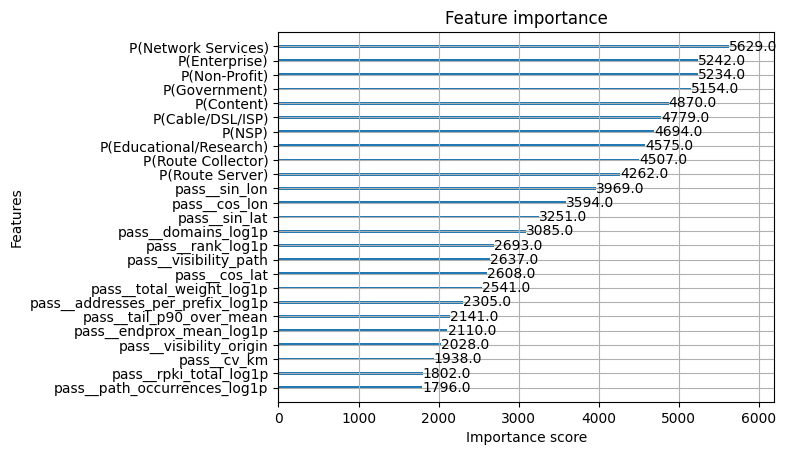

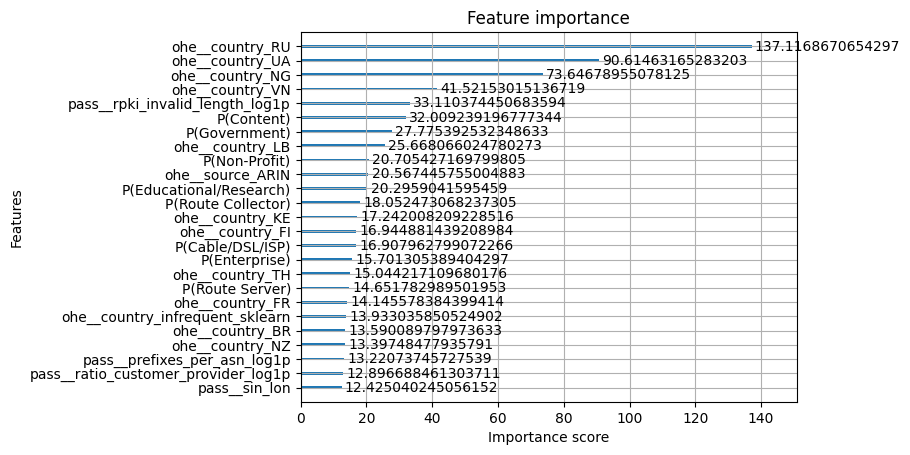

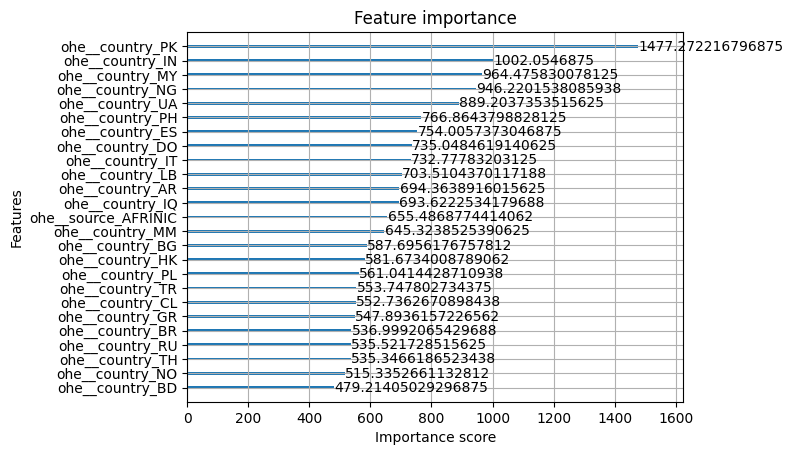

In [19]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
plot_importance(xgb, max_num_features=25)
plot_importance(xgb, importance_type='gain', max_num_features=25)
plot_importance(xgb, importance_type='cover', max_num_features=25)
plt.show()


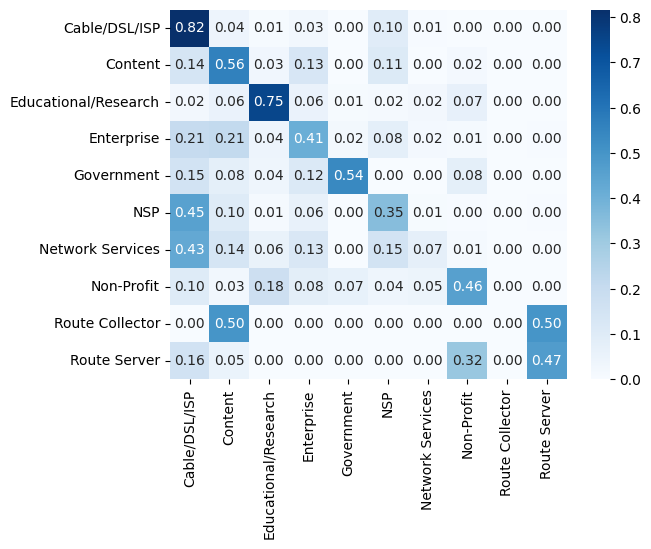

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt
cm = confusion_matrix(y_te,y_pred_te, normalize="true")
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.show()

# Analyse: Warum werden Transit-ASNs als Access klassifiziert?

In [21]:
# Finde Transit-ASNs die als Access falsch klassifiziert wurden
transit_class_idx = 5  # Transit ist Klasse 5
access_class_idx = 0   # Access ist Klasse 0

# Test-Set Labels und Predictions
transit_mask = (y_te == transit_class_idx)
transit_misclassified_as_access = transit_mask & (y_pred_te == access_class_idx)

# Hole die ASN-Indizes
test_asns = peering_df_joined_with_asrank_and_domains_and_geoloc.iloc[idx_te]

# Falsch klassifizierte Transit-ASNs
misclassified_transit = test_asns[transit_misclassified_as_access].copy()
misclassified_transit['predicted'] = 'Access'
misclassified_transit['true_label'] = 'Transit'

print(f"Anzahl Transit-ASNs im Test-Set: {transit_mask.sum()}")
print(f"Davon als Access fehlklassifiziert: {transit_misclassified_as_access.sum()}")
print(f"Das sind {transit_misclassified_as_access.sum() / transit_mask.sum() * 100:.1f}%\n")

# Prüfe verfügbare Spalten
print("Verfügbare Spalten:")
print([col for col in misclassified_transit.columns if 'degree' in col.lower() or 'cone' in col.lower() or 'rank' in col.lower() or col in ['asn', 'org_name', 'country', 'info_type']])

Anzahl Transit-ASNs im Test-Set: 692
Davon als Access fehlklassifiziert: 314
Das sind 45.4%

Verfügbare Spalten:
['asn', 'org_name', 'country', 'info_type', 'rank', 'asnDegree_total', 'asnDegree_customer', 'asnDegree_peer', 'asnDegree_provider', 'cone_numberAsns', 'cone_numberPrefixes', 'cone_numberAddresses']


In [22]:
# Schaue die Features der falsch klassifizierten Transit-ASNs an
cols_to_show = ['asn', 'org_name', 'info_type', 'rank', 'asnDegree_customer', 
                'cone_numberAsns', 'country']

print("=== Transit-ASNs die als Access fehlklassifiziert wurden ===\n")
print(misclassified_transit[cols_to_show].head(15))

# Berechne Statistiken
print("\n=== Statistiken der falsch klassifizierten Transit-ASNs ===")
print(f"Median Rank: {misclassified_transit['rank'].median():.0f}")
print(f"Median Customer Degree: {misclassified_transit['asnDegree_customer'].median():.0f}")
print(f"Median Cone Size: {misclassified_transit['cone_numberAsns'].median():.0f}")

# Vergleiche mit korrekt klassifizierten Transit-ASNs
correctly_classified_transit = transit_mask & (y_pred_te == transit_class_idx)
correct_transit = test_asns[correctly_classified_transit].copy()

print("\n=== Statistiken der KORREKT klassifizierten Transit-ASNs ===")
print(f"Median Rank: {correct_transit['rank'].median():.0f}")
print(f"Median Customer Degree: {correct_transit['asnDegree_customer'].median():.0f}")
print(f"Median Cone Size: {correct_transit['cone_numberAsns'].median():.0f}")

=== Transit-ASNs die als Access fehlklassifiziert wurden ===

          asn                                           org_name info_type  \
1009    49594           altitude infrastructure exploitation sas       NSP   
4030    53132                mega grupo de telecomunicações ltda       NSP   
9636   136384                      optix pakistan (pvt.) limited       NSP   
9672   262812                        k.h.d. silvestri e cia ltda       NSP   
7938   266188                                   a m telecom ltda       NSP   
5290   131270                        planet technology group ltd       NSP   
9227   270444                                        zbl telecom       NSP   
2390    37628                                   kab technologies       NSP   
17104  263218  internet telecomunication company de guatemala...       NSP   
4520   198761                                   simac it nl b.v.       NSP   
16096   50812                                  axess online sarl       NSP   
38

# Detailanalyse: AS28458 - Warum wird dieser "große" Transit als Access klassifiziert?

In [23]:
# Analysiere ALLE Transit-Fehlklassifikationen (nicht nur Access)
transit_class_idx = 5

# Alle Transit-ASNs im Test-Set
transit_mask = (y_te == transit_class_idx)
total_transit = transit_mask.sum()

# Korrekt klassifiziert
transit_correct = (transit_mask & (y_pred_te == transit_class_idx)).sum()

# Breakdown aller Fehlklassifikationen
print(f"=== Transit-Klassifikation Breakdown ===\n")
print(f"Total Transit-ASNs im Test: {total_transit}")
print(f"Korrekt klassifiziert: {transit_correct} ({transit_correct/total_transit*100:.1f}%)")
print(f"\nFehlklassifikationen:")

for class_idx, class_name in enumerate(label_names):
    if class_idx == transit_class_idx:
        continue  # Skip Transit selbst
    
    misclassified_as = (transit_mask & (y_pred_te == class_idx)).sum()
    if misclassified_as > 0:
        percentage = misclassified_as / total_transit * 100
        print(f"  Transit → {class_name}: {misclassified_as} ({percentage:.1f}%)")
        
        # Zeige Statistiken für diese Fehlklassifikation
        mask = transit_mask & (y_pred_te == class_idx)
        misclass_subset = test_asns[mask]
        
        median_rank = misclass_subset['rank'].median()
        median_customer = misclass_subset['asnDegree_customer'].median()
        median_cone = misclass_subset['cone_numberAsns'].median()
        
        print(f"     → Median Rank: {median_rank:.0f}, Customer: {median_customer:.0f}, Cone: {median_cone:.0f}")

=== Transit-Klassifikation Breakdown ===

Total Transit-ASNs im Test: 692
Korrekt klassifiziert: 243 (35.1%)

Fehlklassifikationen:
  Transit → Cable/DSL/ISP: 314 (45.4%)
     → Median Rank: 16768, Customer: 0, Cone: 1
  Transit → Content: 71 (10.3%)
     → Median Rank: 18052, Customer: 0, Cone: 1
  Transit → Educational/Research: 9 (1.3%)
     → Median Rank: 33673, Customer: 0, Cone: 1
  Transit → Enterprise: 44 (6.4%)
     → Median Rank: 35510, Customer: 0, Cone: 1
  Transit → Network Services: 5 (0.7%)
     → Median Rank: 44909, Customer: 0, Cone: 1
  Transit → Non-Profit: 3 (0.4%)
     → Median Rank: 31669, Customer: 0, Cone: 1
  Transit → Route Server: 3 (0.4%)
     → Median Rank: 66977, Customer: 0, Cone: 1


In [24]:
# AS28458: ientc s de rl de cv (Mexiko)
# Rank: 850 (gut!), Customer Degree: 32, Cone: 44
# Das ist ein ECHTER Transit-Provider, aber wird als Access klassifiziert

asn_of_interest = 28458
row = peering_df_joined_with_asrank_and_domains_and_geoloc[
    peering_df_joined_with_asrank_and_domains_and_geoloc['asn'] == asn_of_interest
]

print(f"=== Detailanalyse AS{asn_of_interest} ===\n")
print(f"Org Name: {row['org_name'].values[0]}")
print(f"Label: {row['info_type'].values[0]}")
print(f"Land: {row['country'].values[0]}")
print(f"\nASRank Metriken:")
print(f"  Rank: {row['rank'].values[0]:.0f} (< 1000 = sehr gut!)")
print(f"  Customer Degree: {row['asnDegree_customer'].values[0]:.0f}")
print(f"  Peer Degree: {row['asnDegree_peer'].values[0]:.0f}")
print(f"  Provider Degree: {row['asnDegree_provider'].values[0]:.0f}")
print(f"  Cone Size (ASNs): {row['cone_numberAsns'].values[0]:.0f}")
print(f"  Cone Size (Prefixes): {row['cone_numberPrefixes'].values[0]:.0f}")

# Schaue, was das Modell vorhersagt
test_idx_in_df = row.index[0]
if test_idx_in_df in idx_te:
    # Finde Position im Test-Set
    position_in_test = np.where(idx_te == test_idx_in_df)[0][0]
    
    # Hole Text-Probabilities und finale Prediction
    text_probs = P_text_te[position_in_test]
    final_probs = probs_te_cal[position_in_test]
    prediction = y_pred_te[position_in_test]
    true_label = y_te[position_in_test]
    
    print(f"\n=== Modell-Vorhersage ===")
    print(f"True Label: {label_names[true_label]} (Klasse {true_label})")
    print(f"Prediction: {label_names[prediction]} (Klasse {prediction})")
    print(f"\nText-Probabilities (aus Late-Fusion):")
    for i, prob in enumerate(text_probs):
        print(f"  {label_names[i]}: {prob:.3f}")
    print(f"\nFinale Probabilities (nach XGBoost + Calibration):")
    for i, prob in enumerate(final_probs):
        print(f"  {label_names[i]}: {prob:.3f}")
else:
    print("\nASN ist nicht im Test-Set!")

=== Detailanalyse AS28458 ===

Org Name: ientc s de rl de cv
Label: NSP
Land: MX

ASRank Metriken:
  Rank: 850 (< 1000 = sehr gut!)
  Customer Degree: 32
  Peer Degree: 101
  Provider Degree: 10
  Cone Size (ASNs): 44
  Cone Size (Prefixes): 5586

=== Modell-Vorhersage ===
True Label: NSP (Klasse 5)
Prediction: NSP (Klasse 5)

Text-Probabilities (aus Late-Fusion):
  Cable/DSL/ISP: 0.449
  Content: 0.071
  Educational/Research: 0.037
  Enterprise: 0.124
  Government: 0.006
  NSP: 0.143
  Network Services: 0.114
  Non-Profit: 0.017
  Route Collector: 0.006
  Route Server: 0.016

Finale Probabilities (nach XGBoost + Calibration):
  Cable/DSL/ISP: 0.297
  Content: 0.026
  Educational/Research: 0.006
  Enterprise: 0.023
  Government: 0.002
  NSP: 0.621
  Network Services: 0.020
  Non-Profit: 0.003
  Route Collector: 0.001
  Route Server: 0.001


In [25]:
# Schaue nach mehr Details zu AS28458
print("=== Zusätzliche Informationen ===\n")

# Schaue in die Original-PeeringDB-Daten
peeringdb_row = net_df[net_df['asn'] == 28458]

if not peeringdb_row.empty:
    print("PeeringDB Info:")
    if 'name' in peeringdb_row.columns:
        print(f"  Name: {peeringdb_row['name'].values[0]}")
    if 'aka' in peeringdb_row.columns:
        print(f"  AKA (Also Known As): {peeringdb_row['aka'].values[0]}")
    if 'website' in peeringdb_row.columns:
        print(f"  Website: {peeringdb_row['website'].values[0]}")
    if 'notes' in peeringdb_row.columns:
        notes = peeringdb_row['notes'].values[0]
        if notes and len(str(notes)) > 5:
            print(f"  Notes: {notes[:200]}...")
    
    # Schaue Policy
    if 'policy_general' in peeringdb_row.columns:
        print(f"  Peering Policy: {peeringdb_row['policy_general'].values[0]}")

print("\n=== Interpretation ===")
print("Ein ISP kann SOWOHL Access als auch Transit anbieten!")
print("IENTC könnte ein regionaler ISP in Mexiko sein, der:")
print("  - Endkunden-Internet anbietet (Access)")
print("  - UND Transit für kleinere ISPs verkauft (Transit)")
print("\nDas Label 'Transit' in PeeringDB bedeutet oft:")
print("  'Wir bieten Transit-Services AN', nicht 'Wir sind NUR Transit-Provider'")
print("\nDas Modell klassifiziert nach HAUPTFUNKTION → Access könnte korrekt sein!")

=== Zusätzliche Informationen ===

PeeringDB Info:
  Name: IENTC Telecom Mexico
  AKA (Also Known As): IENTC Telecom Mexico
  Website: https://ientc.com
  Peering Policy: Open

=== Interpretation ===
Ein ISP kann SOWOHL Access als auch Transit anbieten!
IENTC könnte ein regionaler ISP in Mexiko sein, der:
  - Endkunden-Internet anbietet (Access)
  - UND Transit für kleinere ISPs verkauft (Transit)

Das Label 'Transit' in PeeringDB bedeutet oft:
  'Wir bieten Transit-Services AN', nicht 'Wir sind NUR Transit-Provider'

Das Modell klassifiziert nach HAUPTFUNKTION → Access könnte korrekt sein!


In [26]:
## Load Gold Standard data
gold_df = pd.read_csv("/home/jhart/asn-classifier/notebooks/classificator/goldstandard_test_set.csv")
gold_df

,asn,label
0,50017,Non-Profit
1,215628,Network Services
2,14043,Enterprise
3,396422,NSP
4,60812,Route Server
...,...,...
227,205597,Educational/Research
228,7342,NSP
229,151521,Cable/DSL/ISP
230,12403,Cable/DSL/ISP


In [27]:
g_merged = gold_df.merge(peering_df_joined_with_asrank_and_domains_and_geoloc, "left", on="asn")
g_merged

,asn,label,org_name,country,source,info_type,aut_name,rank,asnDegree_total,asnDegree_customer,...,p90_km,p95_km,p99_km,min_km,max_km,pct_ips_le_100km,pct_ips_le_500km,pct_ips_le_1000km,country_entropy_bits,country_entropy_norm
0,50017,Non-Profit,fux eg,DE,RIPE,Non-Profit,fux,31178.0,8.0,0.0,...,3.24,3.24,3.24,0.72,3.24,100.0,100.00,100.00,-0.000000,NaN
1,215628,Network Services,xenox it & kommunikations gmbh,AT,RIPE,Network Services,AS-XENOX-AT,33525.0,21.0,0.0,...,0.00,0.00,0.00,0.00,0.00,100.0,100.00,100.00,-0.000000,NaN
2,14043,Enterprise,"scansource, inc.",US,ARIN,Enterprise,SCANSOURCE,28918.0,5.0,0.0,...,6730.98,6730.98,6756.79,825.24,6756.79,0.0,0.00,67.16,0.678114,0.6781
3,396422,NSP,3ds communications llc,US,ARIN,NSP,3DS-AS01,6497.0,15.0,2.0,...,1694.44,1694.44,1697.67,194.85,2103.24,0.0,81.36,81.36,-0.000000,NaN
4,60812,Route Server,1-ix llc,UA,RIPE,Route Server,IXP-1-IX-UA,4364.0,9.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,205597,Educational/Research,christian frost,DE,RIPE,Educational/Research,FROST,59119.0,19.0,0.0,...,0.00,0.00,0.00,0.00,0.00,100.0,100.00,100.00,-0.000000,NaN
235,7342,NSP,verisign infrastructure & operations,US,ARIN,NSP,VERISIGN-AS,673.0,264.0,60.0,...,5370.96,5412.63,13299.89,2282.57,13299.89,0.0,0.00,0.00,1.568717,0.5229
236,151521,Cable/DSL/ISP,pt. exabit group network,ID,APNIC,Cable/DSL/ISP,IDNIC-EXABIT-ID,34475.0,4.0,0.0,...,10.49,10.49,21.87,3.04,21.87,100.0,100.00,100.00,-0.000000,NaN
237,12403,Cable/DSL/ISP,telecommunication company feonet+ llc,RU,RIPE,Enterprise,FEONET-AS,17393.0,15.0,0.0,...,0.00,0.00,0.00,0.00,0.00,100.0,100.00,100.00,-0.000000,NaN


# Goldstandard Test-Set evaluieren

In [28]:
# =========================
# Test auf Goldstandard-Dataset
# =========================

# 1) Lade dein neues DataFrame (z.B. aus CSV oder vorhandener Variable)
# Annahme: Es hat die Spalten: asn, label (statt info_type), org_name, aut_name?, + alle Numerik-Spalten

# Beispiel: Lade aus CSV
goldstandard_labels_df = pd.read_csv('goldstandard_test_set.csv')  # asn, label


# Merge mit deinen vollständigen Daten um alle Features zu bekommen
# Annahme: peering_df_joined_with_asrank_and_domains_and_geoloc hat alle Features
df_gold = goldstandard_labels_df.merge(
    peering_df_joined_with_asrank_and_domains_and_geoloc,
    on='asn',
    how='inner'
)

print(f"Goldstandard ASNs gefunden: {len(df_gold)}")
print(f"Label-Verteilung:\n{df_gold['label'].value_counts()}")

# 2) Berechne abgeleitete Features (genau wie beim Training)
df_gold["ratio_customer_provider"] = df_gold["asnDegree_customer"] / (df_gold["asnDegree_provider"] + 1)
df_gold["ratio_peer_provider"]     = df_gold["asnDegree_peer"]     / (df_gold["asnDegree_provider"] + 1)
df_gold["ratio_peer_total"]        = df_gold["asnDegree_peer"]     / (df_gold["asnDegree_total"] + 1)
df_gold["frac_customer_total"]     = df_gold["asnDegree_customer"] / (df_gold["asnDegree_total"] + 1)
df_gold["prefixes_per_asn"]        = df_gold["cone_numberPrefixes"] / (df_gold["cone_numberAsns"] + 1)
df_gold["addresses_per_prefix"]    = df_gold["cone_numberAddresses"] / (df_gold["cone_numberPrefixes"] + 1)
df_gold["addresses_per_asn"]       = df_gold["cone_numberAddresses"] / (df_gold["cone_numberAsns"] + 1)

# 3) Erstelle Label-IDs (muss mit Training-Labels übereinstimmen!)
# Verwende den gleichen LabelEncoder wie beim Training
if label_names is not None:
    # Mapping: label_name -> label_id
    label_to_id = {name: i for i, name in enumerate(label_names)}
    df_gold["label_id"] = df_gold["label"].map(label_to_id)
    
    # Prüfe ob alle Labels gemappt wurden
    if df_gold["label_id"].isna().any():
        unknown = df_gold[df_gold["label_id"].isna()]["label"].unique()
        print(f"⚠️ WARNUNG: Unbekannte Labels: {unknown}")
        print(f"   Training kannte nur: {label_names}")
        df_gold = df_gold[df_gold["label_id"].notna()].copy()
    
    df_gold["label_id"] = df_gold["label_id"].astype(int)
else:
    raise ValueError("label_names nicht verfügbar - kann Labels nicht mappen!")

y_gold = df_gold["label_id"].to_numpy()
print(f"\nNach Label-Mapping: {len(df_gold)} ASNs")

# 4) Erstelle Text-Features (genau wie beim Training)
X_text_gold = make_text_df(df_gold, tok)

# 5) Erstelle Numerik-Features (genau wie beim Training)
X_num_gold, _ = build_numeric_frame(df_gold, verbose=False)

# 6) Lade das trainierte Modell
fusion_loaded = FusionModel.load("fusion_xlmr_tfidf_num_xgb_real.joblib")

X_org_name_gold = df_gold["org_name"].fillna("Unknown").astype(str).tolist()
X_aut_name_gold = df_gold["aut_name"].fillna("Unknown").astype(str).tolist()

# 7) Vorhersagen
probs_gold = fusion_loaded.predict_proba(X_text_gold, X_org_name_gold, X_aut_name_gold, X_num_gold)
y_pred_gold = fusion_loaded.predict(X_text_gold, X_org_name_gold, X_aut_name_gold, X_num_gold)

# 8) Evaluation
print("\n" + "="*60)
print("=== GOLDSTANDARD TEST-SET EVALUATION ===")
print("="*60)
print(f"Accuracy: {accuracy_score(y_gold, y_pred_gold):.4f}")
print(f"Macro-F1: {f1_score(y_gold, y_pred_gold, average='macro'):.4f}")
print(f"Weighted-F1: {f1_score(y_gold, y_pred_gold, average='weighted'):.4f}")
print("\n" + classification_report(y_gold, y_pred_gold, target_names=label_names))

# 9) Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_gold = confusion_matrix(y_gold, y_pred_gold)
print("\n=== Confusion Matrix ===")
print("True \\ Pred:", "\t".join([f"{name[:8]}" for name in label_names]))
for i, row in enumerate(cm_gold):
    print(f"{label_names[i][:12]:<12}", "\t".join([f"{v:4d}" for v in row]))

Goldstandard ASNs gefunden: 228
Label-Verteilung:
label
Cable/DSL/ISP           38
Educational/Research    29
NSP                     26
Network Services        25
Government              25
Enterprise              22
Content                 19
Route Server            19
Non-Profit              16
Route Collector          9
Name: count, dtype: int64

Nach Label-Mapping: 228 ASNs

=== GOLDSTANDARD TEST-SET EVALUATION ===
Accuracy: 0.6316
Macro-F1: 0.5690
Weighted-F1: 0.6174

                      precision    recall  f1-score   support

       Cable/DSL/ISP       0.63      0.87      0.73        38
             Content       0.41      0.58      0.48        19
Educational/Research       0.72      0.72      0.72        29
          Enterprise       0.52      0.59      0.55        22
          Government       0.95      0.76      0.84        25
                 NSP       0.68      0.50      0.58        26
    Network Services       0.57      0.32      0.41        25
          Non-Profit    

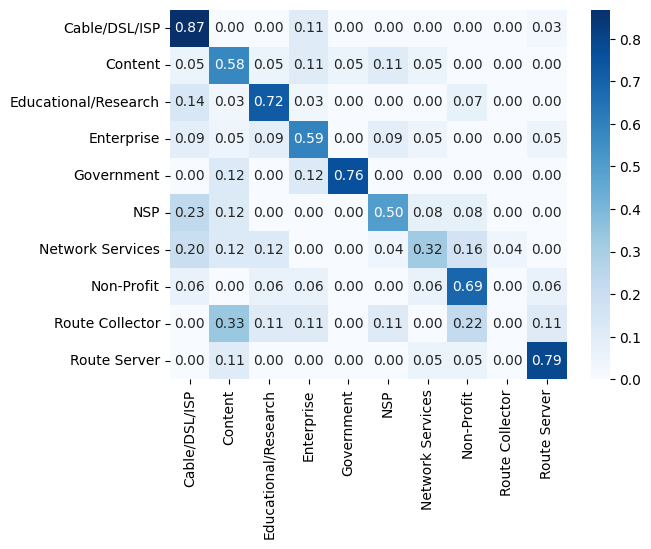

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt
cm = confusion_matrix(y_gold,y_pred_gold, normalize="true")
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.show()

/tmp/ipykernel_1090063/3977741469.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


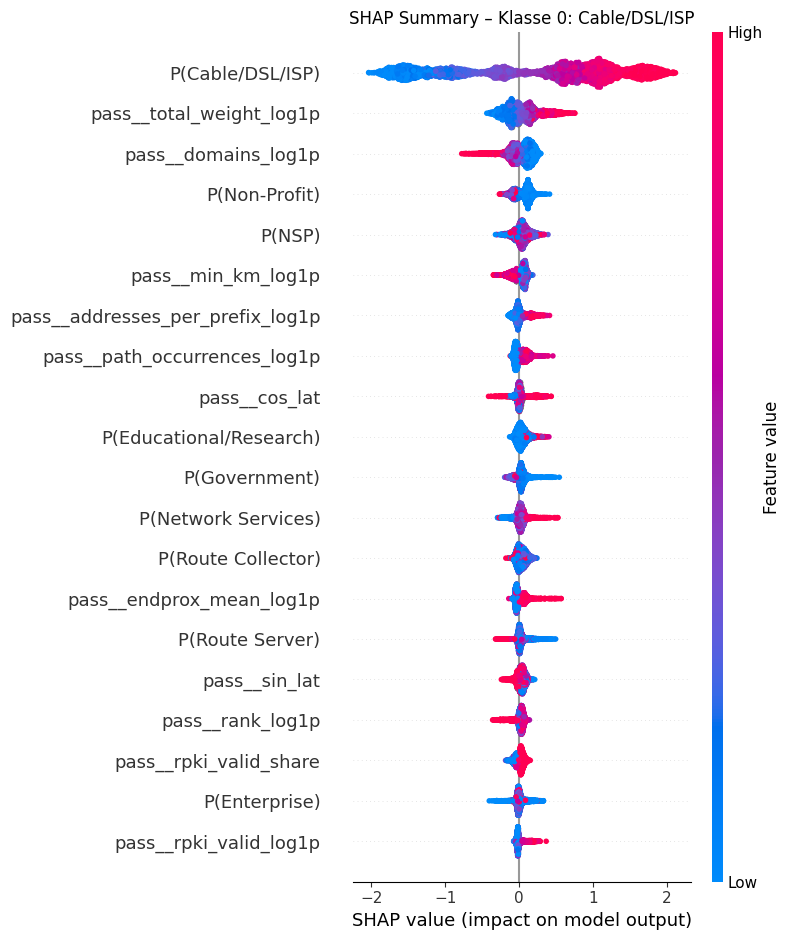

/tmp/ipykernel_1090063/3977741469.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


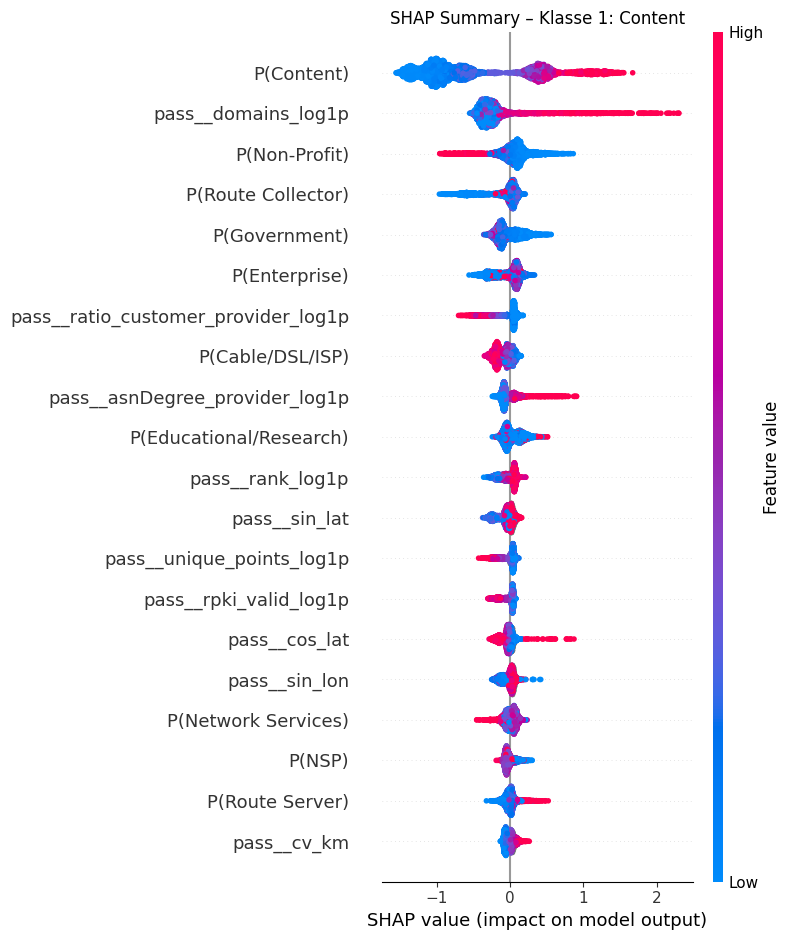

/tmp/ipykernel_1090063/3977741469.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


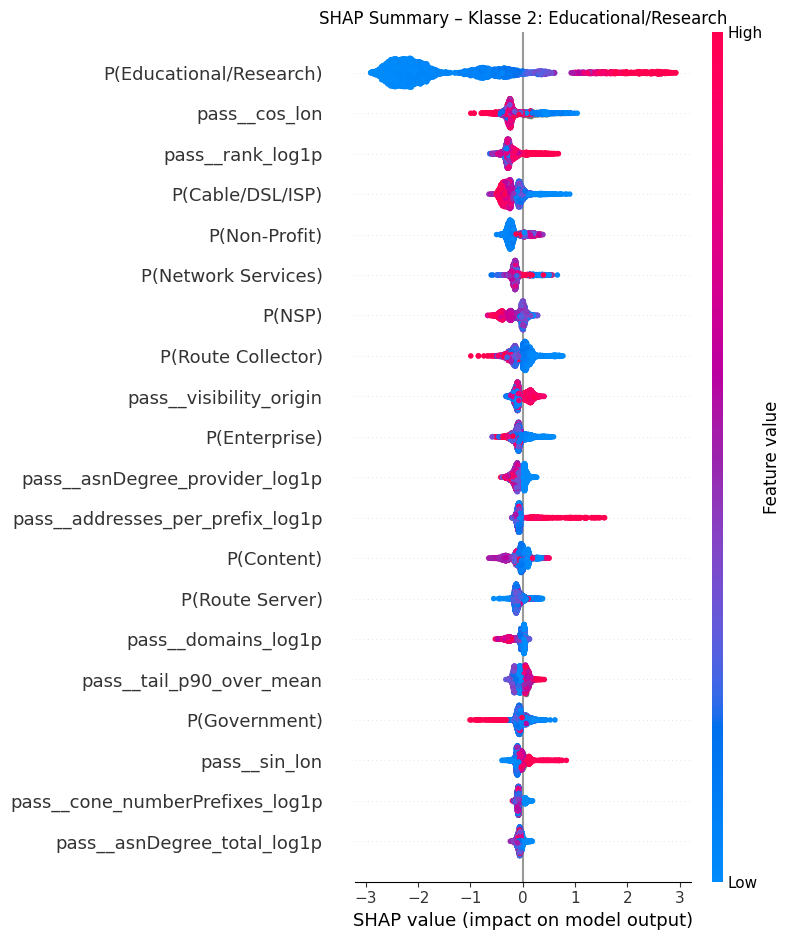

/tmp/ipykernel_1090063/3977741469.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


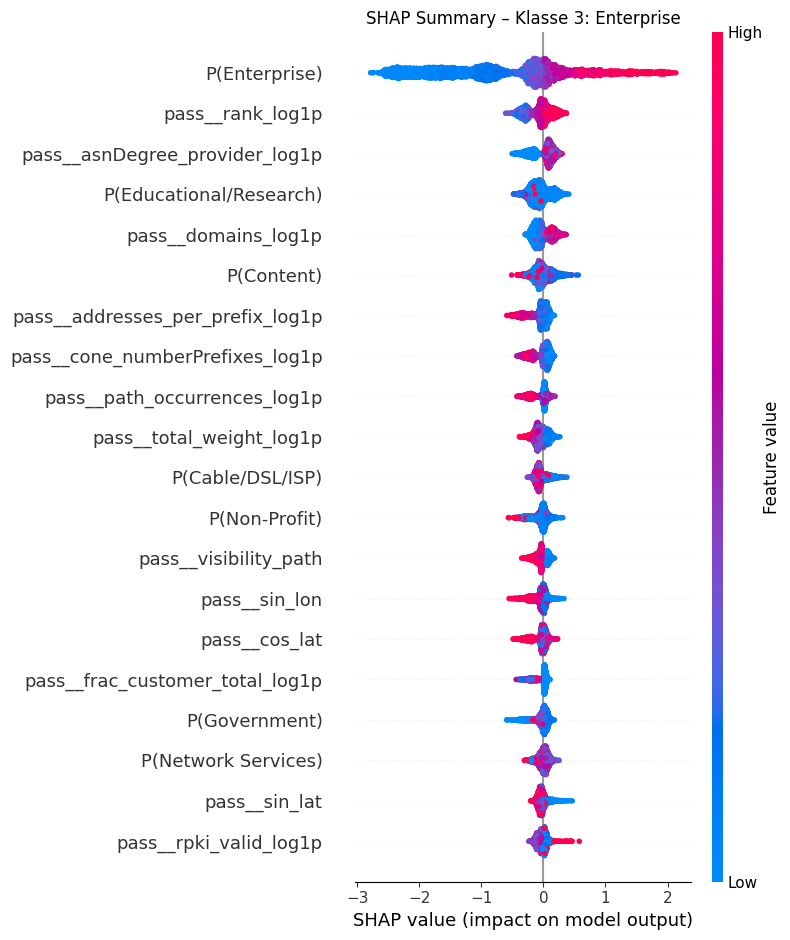

/tmp/ipykernel_1090063/3977741469.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


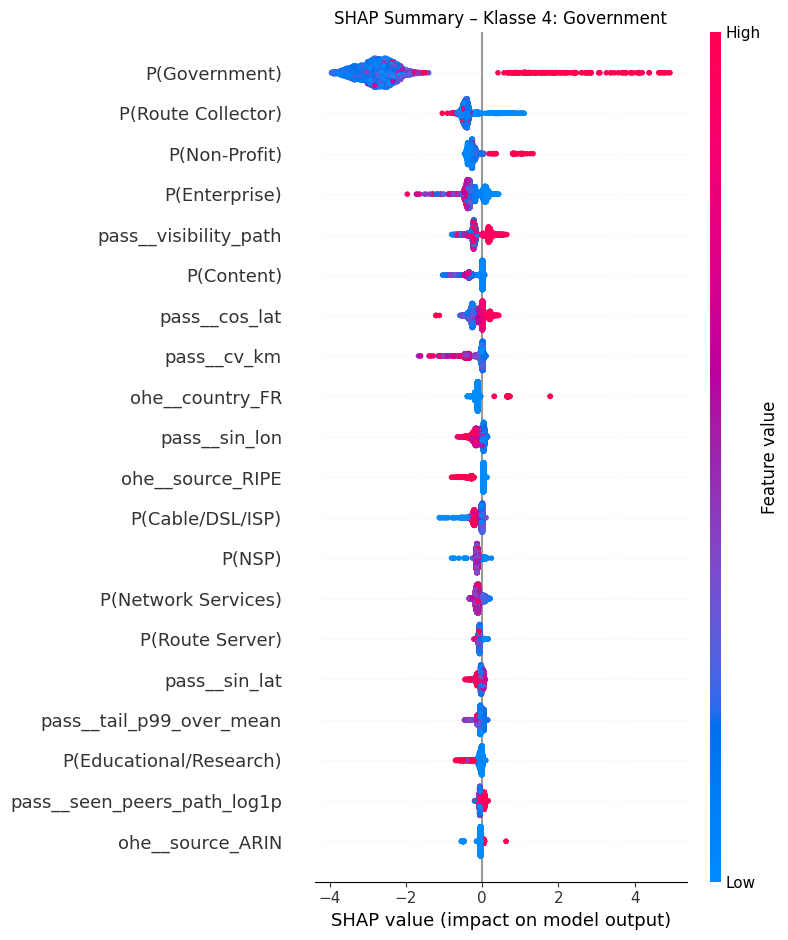

/tmp/ipykernel_1090063/3977741469.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


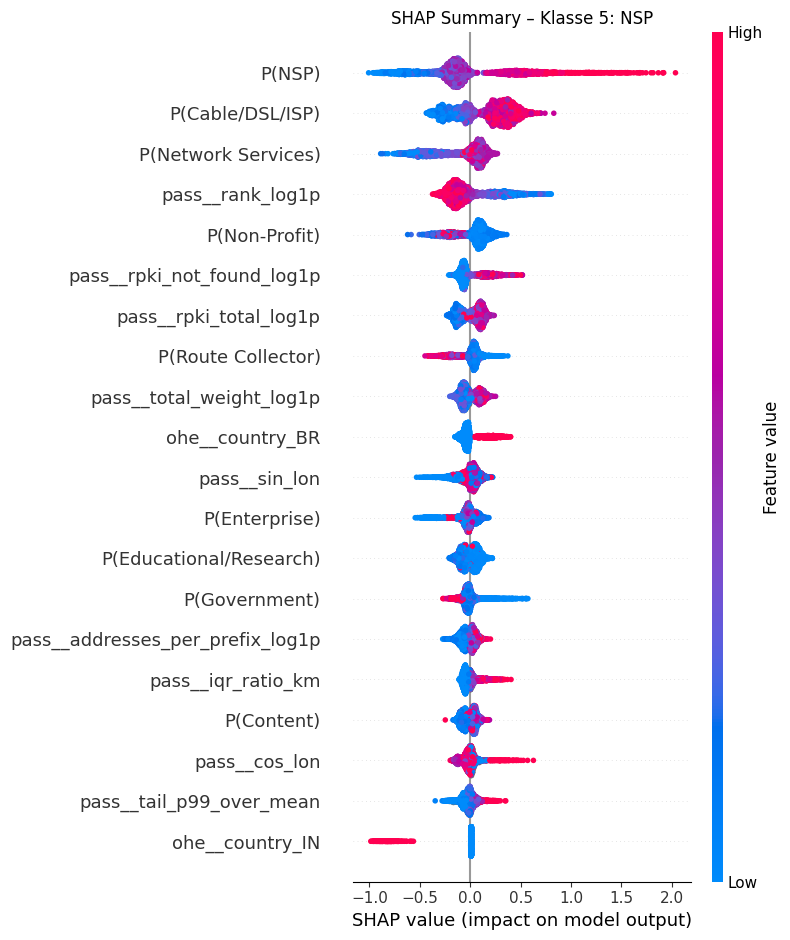

/tmp/ipykernel_1090063/3977741469.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


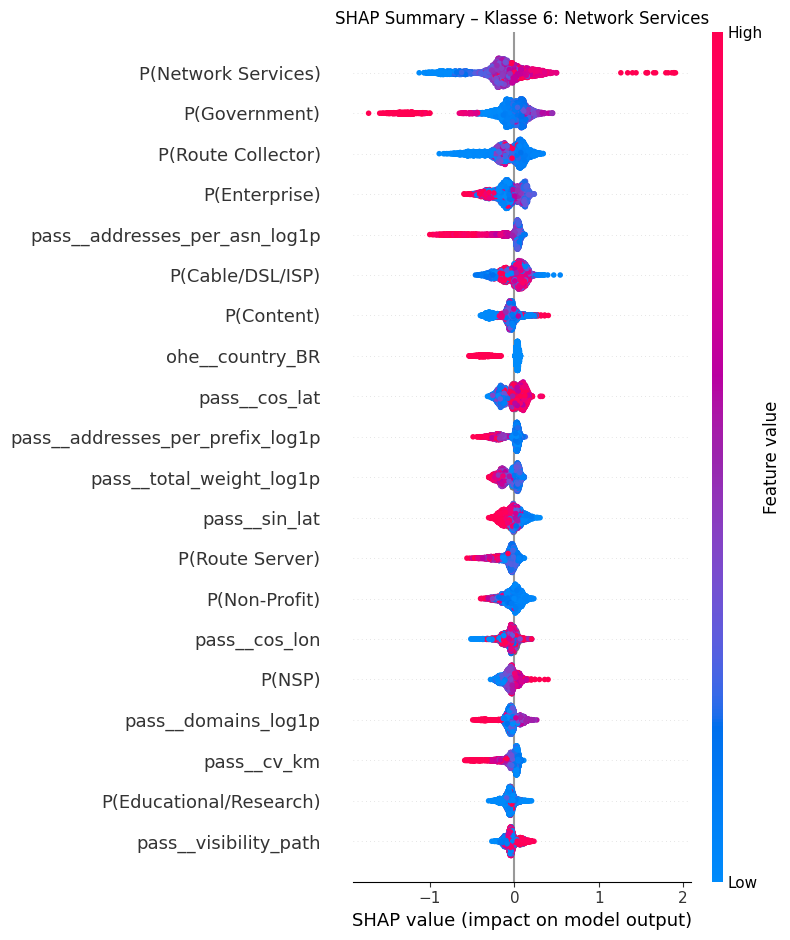

/tmp/ipykernel_1090063/3977741469.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


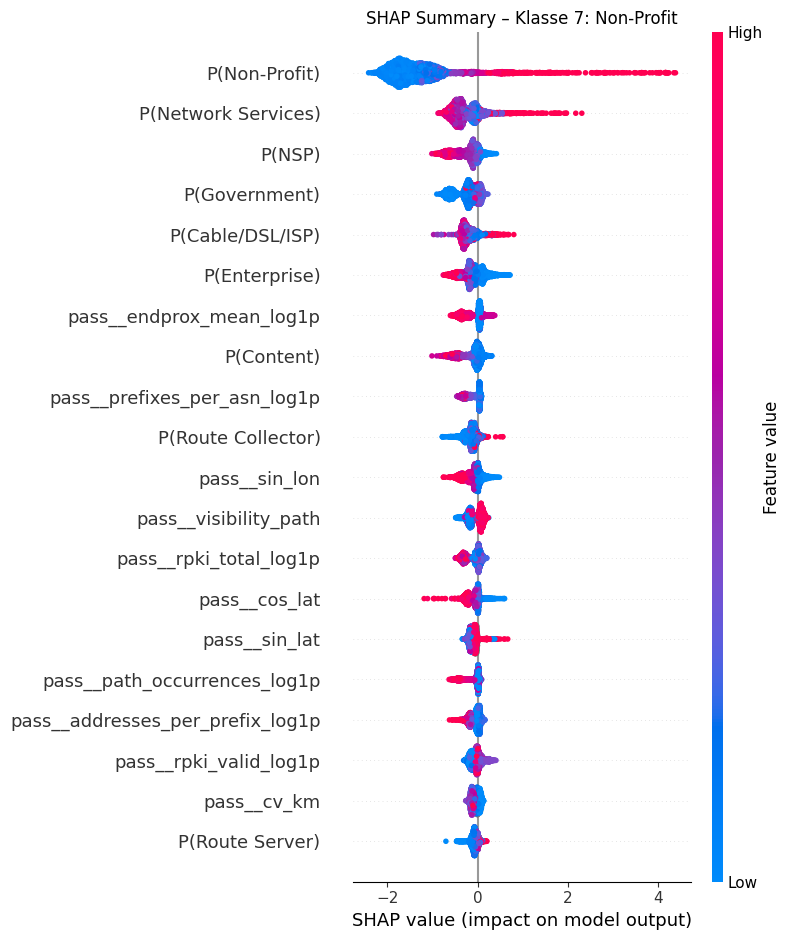

/tmp/ipykernel_1090063/3977741469.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


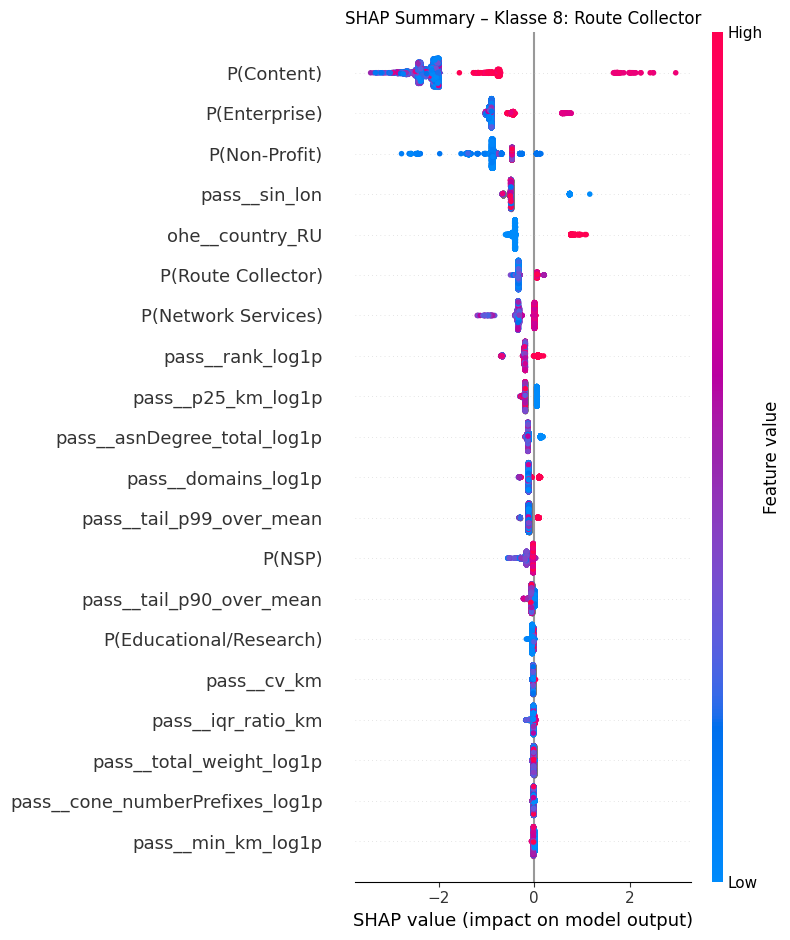

/tmp/ipykernel_1090063/3977741469.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


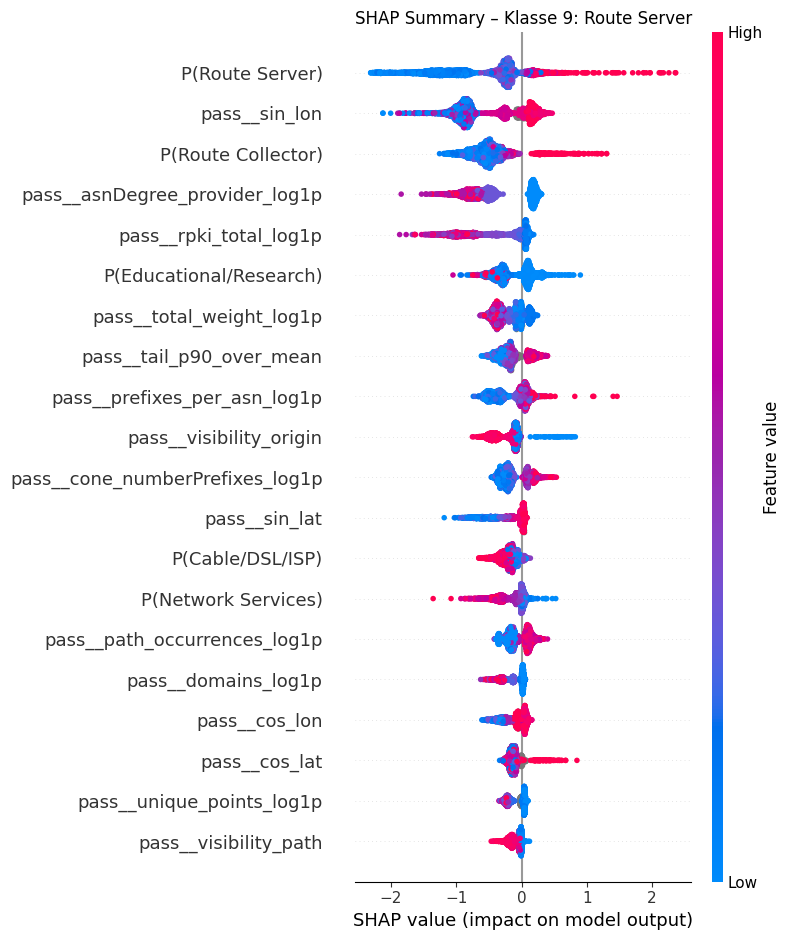

In [30]:
import shap
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_ef_te_df)

num_classes = shap_values.shape[2]

for class_k in range(num_classes):
    shap_values_class_k = shap_values[:, :, class_k]   # (n_samples, n_features)

    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values_class_k,
        X_ef_te_df,
        feature_names=X_ef_te_df.columns,
        show=False
    )
    plt.title(f"SHAP Summary – Klasse {class_k}: {label_names[class_k]}")
    plt.tight_layout()
    plt.show()